* Author: HZQ
* Last modified: 2018/1/31


In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools 
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null 
!apt-get update -qq 2>&1 > /dev/null 
!apt-get -y install -qq google-drive-ocamlfuse fuse 
from google.colab import auth 
auth.authenticate_user() 
from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default() 
import getpass 
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL 
vcode = getpass.getpass() 
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [1]:
!mkdir -p driver
!google-drive-ocamlfuse driver
import os
os.chdir("driver/Colab Notebooks/CategoryRecom_kaggle/")
!ls

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
data	  driver		LICENSE  ReadMe.md	   submit    utils
download  lgbm_importances.png	model	 requirements.txt  timeline


In [0]:
!ls

adc.json  driver  sample_data


In [0]:
!pip install tushare
!pip install statsmodels

In [0]:
!pip install --upgrade pandas

# Main Parts

## Import required packages

In [2]:
import pprint, sys, copy, datetime, functools, pickle, random, pickle, gc, math

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
    
import tushare as ts  # for convenient fetch of stock data
from statsmodels.tsa.stattools import adfuller  # to avoid ModuleNotFoundError: No module named 'pandas.tseries.tools', do not import latest pandas
from statsmodels.tsa.arima_model import ARIMA  # import financial sequence model ARIMA, ModuleNotFoundError: to avoid No module named 'pandas.tseries.tools', do not import latest pandas
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf  # grab params for financial sequence model  # to avoid ModuleNotFoundError: No module named 'pandas.tseries.tools', do not import latest pandas

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
%matplotlib inline

## prepared process


In [0]:
class process_pre_c():
    def __init__(self):
        allocate needed folder path and path checking
        allocate target urls
        allocate strategy for error catch, anti-spider breaking
        
    def init_spider(self):
        choose creator from scrapy, request+BS and so on 
    
    def generate_spider(self):
        application of spider by choosed method
    
    def excute_spider(self):
        excute spider object and return structual texts
        save dataframe object named like xxx_ori
    
    def save_data(self):
        save dataframe xxx_ori as format csv to ".../data_raw"

### load data offline

In [0]:
DATA_ROOT_PATH = "./data/"

In [0]:
data_train_path = DATA_ROOT_PATH + "data_raw/train/train.csv"
data_test_path = DATA_ROOT_PATH + "data_raw/test/test.csv"
data_valid_path = DATA_ROOT_PATH + "data_raw/valid/valid.csv"
data_info_path = DATA_ROOT_PATH  + "data_raw/Data_Dictionary.xlsx"
data_merchants_path = DATA_ROOT_PATH + "data_raw/merchants.csv"
data_his_trans_path = DATA_ROOT_PATH + "data_raw/historical_transactions.csv"
data_new_trans_path = DATA_ROOT_PATH + "data_raw/new_merchant_transactions.csv"

data_train = pd.read_csv(data_train_path)
data_test = pd.read_csv(data_test_path)
data_valid = None
data_info = pd.read_excel(data_info_path, sheetname=[0, 1, 2, 3], header=None)
data_merchants = pd.read_csv(data_merchants_path)
data_new_merchant_transactions = pd.read_csv(data_new_trans_path)

In [0]:
data_historical_transactions = pd.read_csv(data_his_trans_path)

### suppress data

In [0]:
def reduce_mem_usage(df, verbose=True):    
    '''
    INPUT:
    df - expected to be a pandas dataframe containing raw data
    verbose - expected to be a Booler determining whether to print the result of storage decrease
    
    OUTPUT:
    
    This function will suppress INPUT.df by changing data type for storage
    '''    
    numerics = ["int16", "int32", "int64", "float16", "float32", "float64"]
    start_mem = df.memory_usage().sum() / 1024**2    
    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    
    if verbose: print("Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)".format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
data_historical_transactions = reduce_mem_usage(data_historical_transactions)

Mem. usage decreased to 1749.11 Mb (43.7% reduction)


### load data online

## middle process

In [0]:
class process_mid_c():
    def __init__(self):
        allocate room for the variable returned by class process_pre_c
        add needed variable from the below functions
     
    def apply_checkings(self):
        application of serval checkings to the dataframe from statistical checking, completion, survivor bias(Note 2018/12/26: time-related checking has not been ready yet)
    
    def collect_nexus(self):
        collect nexus by the description files and divide data
        expand column data or squeeze outlier column data if needed     
        collect nexus by the number of row vacancy and column vacancy
        collect nexus by statistical indicators like correlation coefficients
        ...
        print self conclusions annotated with date
        
    def fill_na(self):
        if needed, turn categorical data into numberical data
        use Imputer() object from sklearn or the attribute of dataframe ".fillna(, inplace=False/True)"
        save dataframe object named like xxx_filled
        
    def save_data(self):
        save dataframe xxx_filled as format csv to ".../data_processed"

### check data properties

#### check statistical characters

In [0]:
def check_basically(data_path, data):
    '''
    INPUT:
    data_path - expected to be a string showing the store path of INPUT.data 
    data - expected to be a pandas dataframe containing raw data
    
    OUTPUT:
    
    This function will check the statistical characters of INPUT.data
    '''
    type_dict = {}
    name_file = data_path.split("/")[-1]
    name_var = "data_" + name_file[:-4]
    
    print("[Input] File Name: {}, basic checking for VARIABLE \"{}\"".format(name_file, name_var))
    print("[Output] The useful statisitical characters of whole data: ")
    pprint.pprint(data.describe())
    print("\n")
    print("[Output] The fifth rows of raw data: ")
    pprint.pprint(data.head())
    print("\n")
    print("[Output] The shape of file data: ")
    pprint.pprint(data.shape)
    print("\n")
    print("---End Line---")
    print("\n")

In [29]:
check_basically(data_train_path, data_train)
check_basically(data_test_path, data_test)

[Input] File Name: train.csv, basic checking for VARIABLE "data_train"
[Output] The useful statisitical characters of whole data: 
           feature_1      feature_2      feature_3         target
count  201917.000000  201917.000000  201917.000000  201917.000000
mean        3.105311       1.745410       0.565569      -0.393636
std         1.186160       0.751362       0.495683       3.850500
min         1.000000       1.000000       0.000000     -33.219281
25%         2.000000       1.000000       0.000000      -0.883110
50%         3.000000       2.000000       1.000000      -0.023437
75%         4.000000       2.000000       1.000000       0.765453
max         5.000000       3.000000       1.000000      17.965068


[Output] The fifth rows of raw data: 
  first_active_month          card_id  feature_1  feature_2  feature_3  \
0            2017-06  C_ID_92a2005557          5          2          1   
1            2017-01  C_ID_3d0044924f          4          1          0   
2            

In [27]:
check_basically(data_his_trans_path, data_historical_transactions)
check_basically(data_new_trans_path, data_new_merchant_transactions)

[Input] File Name: historical_transactions.csv, basic checking for VARIABLE "data_historical_transactions"
[Output] The useful statisitical characters of whole data: 
            city_id  installments  merchant_category_id     month_lag  \
count  2.911236e+07  2.911236e+07          2.911236e+07  2.911236e+07   
mean   1.293256e+02  6.484954e-01          4.810130e+02 -4.487294e+00   
std    1.042563e+02  2.795577e+00          2.493757e+02  3.588800e+00   
min   -1.000000e+00 -1.000000e+00         -1.000000e+00 -1.300000e+01   
25%    5.300000e+01  0.000000e+00          3.070000e+02 -7.000000e+00   
50%    9.000000e+01  0.000000e+00          4.540000e+02 -4.000000e+00   
75%    2.120000e+02  1.000000e+00          7.050000e+02 -2.000000e+00   
max    3.470000e+02  9.990000e+02          8.910000e+02  0.000000e+00   

       purchase_amount  category_2      state_id  subsector_id  
count     2.911236e+07  26459497.0  2.911236e+07  2.911236e+07  
mean      6.134567e-02         NaN  1.056679e

In [28]:
check_basically(data_merchants_path, data_merchants)

[Input] File Name: merchants.csv, basic checking for VARIABLE "data_merchants"
[Output] The useful statisitical characters of whole data: 
       merchant_group_id  merchant_category_id   subsector_id    numerical_1  \
count      334696.000000         334696.000000  334696.000000  334696.000000   
mean        31028.736143            423.131663      25.116404       0.011476   
std         31623.043426            252.898046       9.807371       1.098154   
min             1.000000             -1.000000      -1.000000      -0.057471   
25%          3612.000000            222.000000      19.000000      -0.057471   
50%         19900.000000            373.000000      27.000000      -0.057471   
75%         51707.250000            683.000000      33.000000      -0.047556   
max        112586.000000            891.000000      41.000000     183.735111   

         numerical_2  avg_sales_lag3  avg_purchases_lag3  active_months_lag3  \
count  334696.000000   334683.000000        3.346960e+05    

#### check repeatablity

In [0]:
def chech_repeatablity(df, flag_groupby):
    '''
    INPUT:
    df - expected to be a pandas dataframe containing raw data
    flag_groupby -  expected to be a string as the indicator of reindexing
    
    OUTPUT:
    flag - expected to be a Booler value indicating the repeatablity of INPUT.df
    
    This function will check the repeatablity of INPUT.df
    '''
    # print(df.shape, df.groupby(flag_groupby).mean().shape)
    flag = not(df.shape[0] == df.groupby(flag_groupby).mean().shape[0])
    
    return flag

In [16]:
print("[Output]The repeatablity checking for training data is {}".format(chech_repeatablity(data_train, "card_id")))
print("[Output]The repeatablity checking for merchant data is {}".format(chech_repeatablity(data_merchants, "merchant_id")))

(334696, 22) (334633, 17)
[Output]The repeatablity checking for merchant data is True


In [18]:
print("[Output]The repeatablity checking for historical merchant transactions data is {}".format(chech_repeatablity(data_historical_transactions, "card_id")))
print("[Output]The repeatablity checking for new merchant transactions data is {}".format(chech_repeatablity(data_new_merchant_transactions, "card_id")))

(29112361, 14) (325540, 8)
[Output]The repeatablity checking for historical merchant transactions data is True
(1963031, 14) (290001, 8)
[Output]The repeatablity checking for new merchant transactions data is True


#### check completion

In [0]:
def check_completion(data_path, data):
    '''
    INPUT:
    data_path - expected to be a string showing the store path of INPUT.data 
    data - expected to be a pandas dataframe containing raw data
    
    OUTPUT:
    
    This function will check the completion of INPUT.data
    '''    
    name_file = data_path.split("/")[-1]
    name_var = "data_" + name_file[:-4]
    
    print("[Input] File Name: {}, completion checking for VARIABLE \"{}\"".format(name_file, name_var))
    collector_df = pd.DataFrame(data.isnull().sum().values, columns=["feature"], index=np.arange(len(data.columns))).set_index(data.columns).sort_values(by=['feature'], ascending=False)
    # print("[Output] The vacancy numbers of whole data: ")
    # pprint.pprint(collector_df)
    print("[Output] The vacancy proportion of whole data: ")
    pprint.pprint(collector_df/data.shape[0]*100)    
    print("\n")
    print("---End Line---")
    print("\n")

In [10]:
check_completion(data_train_path, data_train)
check_completion(data_test_path, data_test)
check_completion(data_merchants_path, data_merchants)
check_completion(data_his_trans_path, data_historical_transactions)
check_completion(data_new_trans_path, data_new_merchant_transactions)

[Input] File Name: train.csv, completion checking for VARIABLE "data_train"
[Output] The vacancy proportion of whole data: 
                    feature
first_active_month        0
card_id                   0
feature_1                 0
feature_2                 0
feature_3                 0
target                    0


---End Line---


[Input] File Name: test.csv, completion checking for VARIABLE "data_test"
[Output] The vacancy proportion of whole data: 
                     feature
first_active_month  0.000809
card_id             0.000000
feature_1           0.000000
feature_2           0.000000
feature_3           0.000000


---End Line---


[Input] File Name: merchants.csv, completion checking for VARIABLE "data_merchants"
[Output] The vacancy proportion of whole data: 
                              feature
category_2                   3.551581
avg_sales_lag6               0.003884
avg_sales_lag12              0.003884
avg_sales_lag3               0.003884
state_id                

#### survivor bias

In [0]:
# @functools.lru_cache(maxsize=128)  # Note 2018/12/14: commented to avoid "TypeError: "DataFrame" objects are mutable"
def check_survivor_bias(data_path, data, label):
    '''
    INPUT:
    data_path - expected to be a string showing the store path of INPUT.data 
    data - expected to be a pandas dataframe containing raw data
    label - expected to be a string indicating the column name of modeling target
    
    OUTPUT:
    
    This function will check the survivor bias of INPUT.data
    '''       
    name_file = data_path.split("/")[-1]
    name_var = "data_" + name_file[:-4]    
    
    print("[Input] File Name: {}, survivor bias checking for VARIABLE \"{}\"".format(name_file, name_var))
    print("[Output] The distribution of target labels: ")
    count = data_train["target"].value_counts()
    print(count.value_counts())
    plt.plot(list(count.index), count.values, "o");  # Not use .plot(kind="scatter") for memory limit, not use .plot.scatter() for not a dataframe
    plt.show()
    # biascollector_survivor_df.to_csv("./model/collector/bias_survivor_collector.csv", index=False)
    print("\n")
    print("---End Line---")
    print("\n")

[Input] File Name: train.csv, survivor bias checking for VARIABLE "data_train"
[Output] The distribution of target labels: 
1       196713
2          281
3           53
4           17
5           11
6            7
7            6
8            5
11           3
10           3
117          1
1630         1
13           1
14           1
17           1
19           1
28           1
2207         1
35           1
81           1
12           1
Name: target, dtype: int64


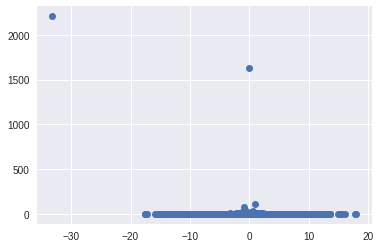



---End Line---




In [0]:
check_survivor_bias(data_train_path, data_train, "target")
# check_survivor_bias(data_test_path, data_test, "")

#### check time-related

|SectionName|Reference|Package|
|:--:|:--:|:--:|
|*check time-related*|[Blog1](https://jianshu.com/p/4130bac8ebe)|Pandas, Statsmodels|
|*check time-related*|[Blog2](https://jianshu.com/p/9066b9e0c7af)|Pandas, Statsmodels|



In [0]:
data_train.rolling?

In [0]:
data_train_copy = copy.copy(data_train)
data_train_dates = list(set(data_train_copy["first_active_month"]))
data_train_copy_slicedBydate = pd.DataFrame(data=[data_train_copy[data_train_copy["first_active_month"] == each_date].iloc[0, :] for each_date in data_train_dates], columns=data_train_copy.columns)
data_train_copy_slicedBydate.set_index(pd.to_datetime(data_train_copy_slicedBydate["first_active_month"]), inplace=True)
data_train_copy_slicedBydate = data_train_copy_slicedBydate.sort_index()

In [0]:
fig2 = plt.figure(figsize=(10, 12));
ax1 = fig2.add_subplot(311) 
plt.plot_date(x=data_train_copy_slicedBydate.index, y=data_train_copy_slicedBydate["target"], xdate=True, marker=None, linestyle="solid", color="darkblue", label="target");
plt.legend(loc="upper left");
ax2 = fig2.add_subplot(312) 
data_train_copy_slicedBydate["target"].rolling(6).mean().plot(color="darkgreen", label="target_rolling_mean");
plt.legend(loc="upper left");
ax3 = fig2.add_subplot(313) 
data_train_copy_slicedBydate["target"].rolling(6).std().plot(color="yellow", label="target_rolling_std");
plt.legend(loc="upper left");
# data_train_copy_slicedBydate_resampled = data_train_copy_slicedBydate.resample("W-MON")  # 数据太多时的降频处理, TODO 2018/12/17: ModuleNotFoundError: No module named "pandas.core.groupby.groupby"; "pandas.core.groupby" is not a package
# data_train_copy_slicedBydate_resampled.plot(color="darkred")

In [0]:
LABELS = ["adf statistics", "p value", "used lag", "Number of oberservation"]


# @functools.lru_cache(maxsize=128)
def check_adfuller(data):
    results = adfuller(x=data, maxlag=12)
    
    for label, result in zip(LABELS, results):
        print(label + ": " + str(result))
        
    if results[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis, accept the null hypothesis")
        print("Data has unit root and is non-stationary")    

In [0]:
check_adfuller(data_train_copy_slicedBydate["target"])

In [0]:
fig1 = plt.figure(figsize=(10, 6));
ax1 = fig1.add_subplot(111) 
print("[Input] Data: {}, visualization for VARIABLE \"{}\"".format("first derivative of \"target\"", "data_train_copy_slicedBydate[\"diff1\"]"))
data_train_copy_slicedBydate["diff1"] = data_train_copy_slicedBydate["target"].diff(1)  # Note 2018/12/13: if needed, use ".dropna()""
# pprint.pprint(data_train_copy_slicedBydate["diff1"])
print("[Output] vacancy numbers")
pprint.pprint("[Output] vacancy numbers: {}".format(data_train_copy_slicedBydate["diff1"].isnull().sum()))
print("\n")
print("[Output] visualization of curve trend")
data_train_copy_slicedBydate["diff1"].plot(color="darkred", label="target_diff1", ax=ax1)
plt.legend(loc="upper left")
plt.show()
# print("\n")
# print("[Output] visualization of adfuller checking result")
# check_adfuller(data_train_copy_slicedBydate["diff1"])  # TODO 2018/12/17: LinAlgError: SVD did not converge 
print("\n")
print("---End Line---")
print("\n")

fig2 = plt.figure(figsize=(10, 6));
ax2 = fig2.add_subplot(111) 
print("[Input] Data Part: {}, visualization for VARIABLE \"{}\"".format("second derivative of \"target\"", "data_train_copy_slicedBydate[\"diff2\"]"))
data_train_copy_slicedBydate["diff2"] = data_train_copy_slicedBydate["diff1"].diff(1)
# pprint.pprint(data_train_copy_slicedBydate["diff2"])
pprint.pprint("[Output] vacancy numbers: {}".format(data_train_copy_slicedBydate["diff2"].isnull().sum()))
print("\n")
print("[Output] visualization of curve trend")
data_train_copy_slicedBydate["diff2"].plot(color="darkblue", label="target_diff2", ax=ax2)
plt.legend(loc="upper left")
plt.show()
# print("\n")
# print("[Output] visualization of adfuller checking result")
# check_adfuller(data_train_copy_slicedBydate["diff2"])  # TODO 2018/12/17: LinAlgError: SVD did not converge 
print("\n")
print("---End Line---")
print("\n")

In [0]:
print("[Input] Variable: {}, determine parameters \"p, q\" for financial sequence model fetched from it".format("ddata_train_copy_slicedBydate[\"diff1\"]"))
print("[Output] visualization of acf curve")
acf = plot_acf(data_train_copy_slicedBydate["target"], lags=20)
plt.show()
print("\n")
print("[Output] visualization of pacf curve")
pacf = plot_pacf(data_train_copy_slicedBydate["target"], lags=20)
plt.show()
model_arima = ARIMA(data_train_copy_slicedBydate["target"], order=(1, 1, 1), freq="W-MON")   # TODO 2018/12/19: check the right descriptions of choosing p and q from acf and pacf plotting 
result_arima = model_arima.fit()
print("\n")
print("---End Line---")
print("\n")

print("[Input] Variable: {}, visualization of fitting results for financial sequence model \"ARIMA\"".format("result_arima"))
print("[Output] visualization of summary")
print(result_arima.summary())
print("\n")
print("[Output] visualization of residual trend and distribution")
result_arima.resid.dropna(axis=0, inplace=True)
fig1 = plt.figure(figsize=(10, 6));
ax1 = fig1.add_subplot(111) 
ax1.set_title("residual in normal format")
result_arima.resid.plot(ax=ax1)
plt.show()
fig2 = plt.figure(figsize=(10, 6));
ax2 = fig2.add_subplot(111) 
ax2.set_title("residual in kde format")
result_arima.resid.plot(ax=ax2, kind="kde")
plt.show()
print("\n")
print("---End Line---")
print("\n")

In [0]:
result_arima

In [0]:
data_train_copy_slicedBydate

In [0]:
print("[Input] Variable: {}, visualization of prediction results for financial sequence model \"ARIMA\"".format("result_arima"))
data_train_copy_slicedBydate["target_pred"] = result_arima.predict(start="2011-12-01", end="2018-02-01", typ="levels")
print("[Output] visualization of prediction curve compared with original curve")
data_train_copy_slicedBydate[["target", "target_pred"]].plot()
plt.show()
# pd.data_range(start="2018-12-1", end="2019-12-1", periods=12, freq="MS")
print("\n")
print("---End Line---")
print("\n")

[Input] Variable: result_arima, visualization of prediction results for financial sequence model 'ARIMA'


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


ValueError: ignored

### collect nexus

#### divide data by category

In [0]:
# @functools.lru_cache(maxsize=128)  # TypeError: "DataFrame" objects are mutable, thus they cannot be hashed
def collect_datatype(data):
    '''
    INPUT:
    data - expected to be a pandas dataframe cotaining raw data
    
    OUTPUT:
    data_type_dict - expected to be a dictionary containg all column data types of INPUT.data
    
    This function will find out every data type of all column data by the assumption of all data in one column share same data type
    '''
    data_type_dict = {each_column: str(data[each_column].dtypes) for each_column in data.columns}
    
    return data_type_dict

In [0]:
# @functools.lru_cache(maxsize=128)  # TypeError: "DataFrame" objects are mutable, thus they cannot be hashed
def collect_datadescription(df, flag_df):
    '''
    INPUT:
    df - expected to be a pandas dataframe containing raw data
    flag_df - expected to be a string indicating the meaning of INPUT.df
    
    OUTPUT:
    data_types_df - expected to be a pandas dataframe containing column data type and description of INPUT.df
    
    This function will obtain column data type and description of INPUT.df
    '''
    data_types_dict = collect_datatype(df)
    data_types_dict_new = {each_col:[data_types_dict[each_col]] for each_col in data_types_dict}
    
    if "train" in flag_df:
        for each_col in data_types_dict:
            data_types_dict_new[each_col].append(data_info[0][data_info[0][0] == each_col][1].values[0])
    if "his" in flag_df:
        for each_col in data_types_dict:
            data_types_dict_new[each_col].append(data_info[1][data_info[1][0] == each_col][1].values[0])
    if "new" in flag_df:
        for each_col in data_types_dict:
            data_types_dict_new[each_col].append(data_info[2][data_info[2][0] == each_col][1].values[0])
    if "merchant" in flag_df:
        for each_col in data_types_dict:
            data_types_dict_new[each_col].append(data_info[3][data_info[3][0] == each_col][1].values[0])
   
    data_types_df = pd.DataFrame(data_types_dict_new, index=[0, 1])
    
    return data_types_df

##### check the whole data

In [0]:
data_types_dict = {"historical_transactions_datatype": collect_datatype(data_historical_transactions), "new_merchant_transactions_datatype": collect_datatype(data_new_merchant_transactions), "merchants_datatype": collect_datatype(data_merchants), "train_datatype": collect_datatype(data_train), "test_datatype": collect_datatype(data_test)}

In [16]:
columns_num, columns_nonnum = {}, {}  # Note 2019/1/31: "columns_nonnum" do not include "columns_nonnum_cate", "columns_nonnum_outlier"
columns_nonnum_cate, columns_nonnum_outlier = {}, {}

for each_csv in data_types_dict:
    columns_num[each_csv] = []
    columns_nonnum[each_csv] = []
    columns_nonnum_cate[each_csv] = []
    columns_nonnum_outlier[each_csv] = []
    
    print("[Output] The non-numbericial columns of {} is: ".format(each_csv))
    
    # pprint.pprint({each_column: [str(type(data_types_dict[each_csv][each_column][0])) if "object" in data_types_dict[each_csv][each_column] else pass] for each_column in list(data_types_dict[each_csv].keys())})
    
    for each_column in data_types_dict[each_csv]:
        if "object" in data_types_dict[each_csv][each_column] or "datetime" in data_types_dict[each_csv][each_column]:
            pprint.pprint("{} is stored as type {}".format(each_column, str(data_types_dict[each_csv][each_column])))
            # columns_nonnum[each_csv].append(each_column)
            if "his" in each_csv:
                temp = set(data_historical_transactions[each_column].dropna())
                if len(temp) == 2:
                    columns_nonnum_cate[each_csv].append(each_column)
                elif len(temp) == 1:
                    columns_nonnum_outlier[each_csv].append(each_column)
                else:
                    columns_nonnum[each_csv].append(each_column)
            elif "new" in each_csv:
                temp = set(data_new_merchant_transactions[each_column].dropna())
                if len(temp) == 2:
                    columns_nonnum_cate[each_csv].append(each_column)
                elif len(temp) == 1:
                    columns_nonnum_outlier[each_csv].append(each_column)
                else:
                    columns_nonnum[each_csv].append(each_column)
            elif "merchants" in each_csv:
                temp = set(data_merchants[each_column].dropna())
                if len(temp) == 2:
                    columns_nonnum_cate[each_csv].append(each_column)
                elif len(temp) == 1:
                    columns_nonnum_outlier[each_csv].append(each_column)
                else:
                    columns_nonnum[each_csv].append(each_column)                
            elif "train" in each_csv:
                temp = set(data_train[each_column].dropna())
                if len(temp) == 2:
                    columns_nonnum_cate[each_csv].append(each_column)
                elif len(temp) == 1:
                    columns_nonnum_outlier[each_csv].append(each_column)
                else:
                    columns_nonnum[each_csv].append(each_column)
            elif "test" in each_csv:
                temp = set(data_test[each_column].dropna())
                if len(temp) == 2:
                    columns_nonnum_cate[each_csv].append(each_column)
                elif len(temp) == 1:
                    columns_nonnum_outlier[each_csv].append(each_column)
                else:
                    columns_nonnum[each_csv].append(each_column)
        else:
            columns_num[each_csv].append(each_column) 
    print("The ratio of non-numbericial columns is {}".format(len(columns_nonnum[each_csv])/len(data_types_dict[each_csv].keys())))
    print("\n")
    gc.collect()
    sys._clear_type_cache()

[Output] The non-numbericial columns of historical_transactions_datatype is: 
'authorized_flag is stored as type object'
'card_id is stored as type object'
'category_1 is stored as type object'
'category_3 is stored as type object'
'merchant_id is stored as type object'
'purchase_date is stored as type object'
The ratio of non-numbericial columns is 0.2857142857142857


[Output] The non-numbericial columns of new_merchant_transactions_datatype is: 
'authorized_flag is stored as type object'
'card_id is stored as type object'
'category_1 is stored as type object'
'category_3 is stored as type object'
'merchant_id is stored as type object'
'purchase_date is stored as type object'
The ratio of non-numbericial columns is 0.2857142857142857


[Output] The non-numbericial columns of merchants_datatype is: 
'merchant_id is stored as type object'
'category_1 is stored as type object'
'most_recent_sales_range is stored as type object'
'most_recent_purchases_range is stored as type object'
'cate

##### check individual data

In [0]:
data_train_des = collect_datadescription(data_train, "train")
data_train_des

,card_id,feature_1,feature_2,feature_3,first_active_month,target
0,object,int64,int64,int64,object,float64
1,Unique card identifier,Anonymized card categorical feature,Anonymized card categorical feature,Anonymized card categorical feature,"'YYYY-MM', month of first purchase",Loyalty numerical score calculated 2 months af...


In [0]:
data_train_des[columns_nonnum["train_datatype"]]

In [0]:
data_historical_transactions_des = collect_datadescription(data_historical_transactions, "his")
data_historical_transactions_des

,authorized_flag,card_id,category_1,category_2,category_3,city_id,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id
0,object,object,object,float16,object,int16,int16,int16,object,int8,float32,object,int8,int8
1,"Y' if approved, 'N' if denied",Card identifier,anonymized category,anonymized category,anonymized category,City identifier (anonymized ),number of installments of purchase,Merchant category identifier (anonymized ),Merchant identifier (anonymized),month lag to reference date,Normalized purchase amount,Purchase date,State identifier (anonymized ),Merchant category group identifier (anonymized )


In [0]:
data_historical_transactions_des[columns_nonnum["historical_transactions_datatype"]]

In [0]:
data_new_merchant_transactions_des = collect_datadescription(data_new_merchant_transactions, "new")
data_new_merchant_transactions_des

,authorized_flag,card_id,category_1,category_2,category_3,city_id,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id
0,object,object,object,float64,object,int64,int64,int64,object,int64,float64,object,int64,int64
1,"Y' if approved, 'N' if denied",Card identifier,anonymized category,anonymized category,anonymized category,City identifier (anonymized ),number of installments of purchase,Merchant category identifier (anonymized ),Merchant identifier (anonymized),month lag to reference date,Normalized purchase amount,Purchase date,State identifier (anonymized ),Merchant category group identifier (anonymized )


In [0]:
data_new_merchant_transactions[columns_nonnum["new_merchant_transactions_datatype"]]

In [0]:
data_merchants_des = collect_datadescription(data_merchants, "merchant")
data_merchants_des

,active_months_lag12,active_months_lag3,active_months_lag6,avg_purchases_lag12,avg_purchases_lag3,avg_purchases_lag6,avg_sales_lag12,avg_sales_lag3,avg_sales_lag6,category_1,...,city_id,merchant_category_id,merchant_group_id,merchant_id,most_recent_purchases_range,most_recent_sales_range,numerical_1,numerical_2,state_id,subsector_id
0,int64,int64,int64,float64,float64,float64,float64,float64,float64,object,...,int64,int64,int64,object,object,object,float64,float64,int64,int64
1,Quantity of active months within last 12 months,Quantity of active months within last 3 months,Quantity of active months within last 6 months,Monthly average of transactions in last 12 mon...,Monthly average of transactions in last 3 mont...,Monthly average of transactions in last 6 mont...,Monthly average of revenue in last 12 months d...,Monthly average of revenue in last 3 months di...,Monthly average of revenue in last 6 months di...,anonymized category,...,City identifier (anonymized ),Unique identifier for merchant category (anony...,Merchant group (anonymized ),Unique merchant identifier,Range of quantity of transactions in last acti...,Range of revenue (monetary units) in last acti...,anonymized measure,anonymized measure,State identifier (anonymized ),Merchant category group (anonymized )


In [0]:
data_merchants_des[columns_nonnum["merchants_datatype"]]

##### read or save original division

In [0]:
# fw = open(DATA_ROOT_PATH+"/collector/data_type_num.pkl", "wb")
# pickle.dump(columns_num, fw)
# fw.close()
# fw = open(DATA_ROOT_PATH+"/collector/data_type_nonnum.pkl", "wb")
# pickle.dump(columns_nonnum, fw)
# fw.close()
# fw = open(DATA_ROOT_PATH+"/collector/data_type_categorical.pkl", "wb")
# pickle.dump(columns_nonnum_cate, fw)
# fw.close()
# fw = open(DATA_ROOT_PATH+"/collector/data_type_nonnum_outlier.pkl", "wb")
# pickle.dump(columns_nonnum_outlier, fw)
# fw.close()

fr = open(DATA_ROOT_PATH+"/collector/data_type_num.pkl", "rb")
columns_num = pickle.load(fr)
fr.close()
fr = open(DATA_ROOT_PATH+"/collector/data_type_nonnum.pkl", "rb")
columns_nonnum = pickle.load(fr)
fr.close()
fr = open(DATA_ROOT_PATH+"/collector/data_type_categorical.pkl", "rb")
columns_nonnum_cate = pickle.load(fr)
fr.close()
fr = open(DATA_ROOT_PATH+"/collector/data_type_nonnum_outlier.pkl", "rb")
columns_nonnum_outlier = pickle.load(fr)
fr.close()

#### expand training and testing data

#####  deal with outliers

* outliers brought by modeling target distribution

In [0]:
data_train["Outlier"] = 0
data_train.loc[data_train["target"] < -30, "Outlier"] = 1
data_train.loc[data_train["target"] == 0, "Outlier"] = 1

* outliers brought by column data distribution

In [90]:
columns_nonnum_outlier

{'historical_transactions_datatype': [],
 'merchants_datatype': [],
 'new_merchant_transactions_datatype': ['authorized_flag'],
 'test_datatype': [],
 'train_datatype': []}

In [0]:
data_new_merchant_transactions.drop(['authorized_flag'], axis=1, inplace=True)

* outliers brought by vacancy which is larger than 3% of total number of data

In [0]:
data_merchants.drop(["category_2"], axis=1, inplace=True)

In [0]:
data_historical_transactions.drop(["category_2"], axis=1, inplace=True)
columns_num["historical_transactions_datatype"].remove("category_2")
data_historical_transactions.drop(index=data_historical_transactions[data_historical_transactions.merchant_id.isnull()].index, axis=0, inplace=True)

In [0]:
data_new_merchant_transactions.drop(["category_2"], axis=1, inplace=True)
columns_num["new_merchant_transactions_datatype"].remove("category_2")
data_new_merchant_transactions.drop(index=data_new_merchant_transactions[data_new_merchant_transactions.merchant_id.isnull()].index, axis=0, inplace=True)

#####  UDF features

###### deal with categorical data

In [0]:
def apply_binarize(df, df_flag):
    '''
    INPUT:
    df - expected to be a pandas dataframe containing raw data
    df_flag - expected to be a string expected to be a string indicating the meaning of INPUT.df
    
    OUTPUT:
    df - expected to be a pandas dataframe containing categorical data after binarized
    
    This function will binarize categorical data of INPUT.df
    '''
    if "his" in df_flag:
        for column in columns_nonnum_cate["historical_transactions_datatype"]:
            df[column] = df[column].map({"Y":1, "N":0})
    elif "merchant" in df_flag:
        for column in columns_nonnum_cate["merchants_datatype"]:
            df[column] = df[column].map({"Y":1, "N":0})
    elif "new" in df_flag:
        for column in columns_nonnum_cate["new_merchant_transactions_datatype"]:
            df[column] = df[column].map({"Y":1, "N":0})
    
    return df

In [59]:
columns_nonnum_cate

{'historical_transactions_datatype': ['authorized_flag', 'category_1'],
 'merchants_datatype': ['category_1', 'category_4'],
 'new_merchant_transactions_datatype': ['category_1'],
 'test_datatype': [],
 'train_datatype': []}

In [0]:
data_new_merchant_transactions = apply_binarize(data_new_merchant_transactions, "new")
data_historical_transactions = apply_binarize(data_historical_transactions, "his")
data_merchants = apply_binarize(data_merchants, "merchant")

In [0]:
# data_train.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_mod_20190131.csv", index=None)
# data_test.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_mod_20190131.csv", index=None)
# data_historical_transactions.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_mod_20190131.csv", index=None)
# data_new_merchant_transactions.to_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_mod_20190131.csv", index=None)
# data_merchants.to_csv(DATA_ROOT_PATH+"data_processed/train/data_merchants_mod_20190131.csv", index=None)

data_train = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_mod_20190131.csv")
data_test = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_mod_20190131.csv")
data_historical_transactions = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_mod_20190131.csv")
data_new_merchant_transactions = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_mod_20190131.csv")
data_merchants = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_merchants_mod_20190131.csv")
data_historical_transactions = reduce_mem_usage(data_historical_transactions)

In [0]:
# TODO 2019/1/31: make modification for the missing constriant "index=None"


data_train.drop(["Unnamed: 0"], axis=1, inplace=True)
data_test.drop(["Unnamed: 0"], axis=1, inplace=True)
data_new_merchant_transactions.drop(["Unnamed: 0"], axis=1, inplace=True)
data_merchants.drop(["Unnamed: 0"], axis=1, inplace=True)
data_historical_transactions.drop(["Unnamed: 0"], axis=1, inplace=True)

###### deal with mixed data

|FunctionName|Reference|
|:--:|:--:|:--:|
|apply_extraction2datedata|[My first kernel](https://www.kaggle.com/chauhuynh/my-first-kernel-3-699/)



In [0]:
month_dict = {1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June", 7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"}


def modify_hour2string(each_time):
    if each_time > 4 and each_time < 12:
        return "Morning"
    elif each_time >= 12 and each_time < 17:
        return "Afternoon"
    elif each_time >= 17 and each_time < 21:
        return "Evening"
    else:
        return "Night"

In [0]:
def apply_extraction2datedata(df, df_flag):
    '''
    INPUT:
    df - expected to be a pandas dataframe containing raw data
    df_flag - expected to be a string expected to be a string indicating the meaning of INPUT.df
    
    OUTPUT:
    df - expected to be a pandas dataframe containing expanded data after extraction
    
    This function will extract numberical data from date data of INPUT.df
    '''  
    if "his" in df_flag or "new" in df_flag:
        df["purchase_date"] = pd.to_datetime(df["purchase_date"])
        df["purchase_year"] = df["purchase_date"].dt.year
        df["purchase_weekofyear"] = df["purchase_date"].dt.weekofyear
        df["purchase_month"] = df["purchase_date"].dt.month
        df["purchase_month"] = df["purchase_month"].map(month_dict)
        df["purchase_dayofweek"] = df["purchase_date"].dt.dayofweek
        df["purchase_weekend"] = (df.purchase_date.dt.weekday >= 5).astype(int)
        df["purchase_hour"] = df["purchase_date"].dt.hour
        df["purchase_diarysession"] = df["purchase_hour"].apply(lambda x: modify_hour2string(x))
        df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30
        df['month_diff'] += df['month_lag']
        df.drop(["purchase_date"], axis=1, inplace=True)
    elif "train" in df_flag or "test" in df_flag:
        df["first_active_month"] = pd.to_datetime(df["first_active_month"])
        df["first_active_month_dayofweek"] = df["first_active_month"].dt.dayofweek
        df["first_active_month_weekofyear"] = df["first_active_month"].dt.weekofyear
        df["first_active_month_month"] = df["first_active_month"].dt.month
        df["first_active_month_month"] = df["first_active_month_month"].map(month_dict)
        df["first_active_month_elapsed_time"] = (datetime.datetime.today() - df["first_active_month"]).dt.days
        df.drop(["first_active_month"], axis=1, inplace=True)
    
    gc.collect()
    sys._clear_type_cache()
    
    return df

In [100]:
columns_nonnum_mixed = {each_csv:[] for each_csv in columns_nonnum}
for each_csv in columns_nonnum_mixed:
    if "train" in each_csv or "test" in each_csv:
        columns_nonnum_mixed[each_csv].append("first_active_month")
    elif "his" in each_csv or "new" in each_csv:
        columns_nonnum_mixed[each_csv].append("purchase_date")
columns_nonnum_mixed

{'historical_transactions_datatype': ['purchase_date'],
 'merchants_datatype': [],
 'new_merchant_transactions_datatype': ['purchase_date'],
 'test_datatype': ['first_active_month'],
 'train_datatype': ['first_active_month']}

In [0]:
data_historical_transactions = apply_extraction2datedata(data_historical_transactions, "his")
print("[Output] Finish one task......")
data_new_merchant_transactions = apply_extraction2datedata(data_new_merchant_transactions, "new")
print("[Output] Finish two tasks......")
data_train = apply_extraction2datedata(data_train, "train")
print("[Output] Finish three tasks......")
data_test = apply_extraction2datedata(data_test, "test")
print("[Output] All done!")

######  combine all in one table

|FunctionName|Reference|
|:--:|:--:|
|Aggregate transactions|[Elo world](https://www.kaggle.com/fabiendaniel/elo-world)



* check data type

In [0]:
data_types_dict = {"historical_transactions_datatype": collect_datatype(data_historical_transactions), "new_merchant_transactions_datatype": collect_datatype(data_new_merchant_transactions), "merchants_datatype": collect_datatype(data_merchants), "train_datatype": collect_datatype(data_train), "test_datatype": collect_datatype(data_test)}

In [43]:
columns_num, columns_nonnum = {}, {}

for each_csv in data_types_dict:
    columns_num[each_csv] = []
    columns_nonnum[each_csv] = []
    
    print("[Output] The non-numbericial columns of {} is: ".format(each_csv))
    
    # pprint.pprint({each_column: [str(type(data_types_dict[each_csv][each_column][0])) if "object" in data_types_dict[each_csv][each_column] else pass] for each_column in list(data_types_dict[each_csv].keys())})
    
    for each_column in data_types_dict[each_csv]:
        if "object" in data_types_dict[each_csv][each_column] or "datetime" in data_types_dict[each_csv][each_column]:
            pprint.pprint("{} is stored as type {}".format(each_column, str(data_types_dict[each_csv][each_column])))
            columns_nonnum[each_csv].append(each_column)
        else:
            columns_num[each_csv].append(each_column) 
    print("The ratio of non-numbericial columns is {}".format(len(columns_nonnum[each_csv])/len(data_types_dict[each_csv].keys())))
    print("\n")
    gc.collect()
    sys._clear_type_cache()

[Output] The non-numbericial columns of historical_transactions_datatype is: 
'card_id is stored as type object'
'category_3 is stored as type object'
'merchant_id is stored as type object'
'purchase_month is stored as type object'
'purchase_diarysession is stored as type object'
The ratio of non-numbericial columns is 0.25


[Output] The non-numbericial columns of new_merchant_transactions_datatype is: 
'card_id is stored as type object'
'category_3 is stored as type object'
'merchant_id is stored as type object'
'purchase_month is stored as type object'
'purchase_diarysession is stored as type object'
The ratio of non-numbericial columns is 0.2631578947368421


[Output] The non-numbericial columns of merchants_datatype is: 
'merchant_id is stored as type object'
'most_recent_sales_range is stored as type object'
'most_recent_purchases_range is stored as type object'
The ratio of non-numbericial columns is 0.14285714285714285


[Output] The non-numbericial columns of train_datatype is

* apply numberical transformation

In [0]:
data_train = pd.get_dummies(data_train, columns=["first_active_month_month"])
data_test = pd.get_dummies(data_test, columns=["first_active_month_month"])
data_historical_transactions = pd.get_dummies(data_historical_transactions, columns=["category_3", "purchase_month", "purchase_diarysession"])
data_new_merchant_transactions = pd.get_dummies(data_new_merchant_transactions, columns=["category_3", "purchase_month", "purchase_diarysession"])
data_merchants = pd.get_dummies(data_merchants, columns=["most_recent_sales_range", "most_recent_purchases_range"])

In [0]:
data_train.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_mod2_20190131.csv")
print("[Output] Finish one task......")
data_test.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_mod2_20190131.csv")
print("[Output] Finish two tasks......")
data_historical_transactions.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_mod2_20190131.csv")
print("[Output] Finish three tasks......")
data_new_merchant_transactions.to_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_mod2_20190131.csv")
print("[Output] Finish four tasks......")
data_merchants.to_csv(DATA_ROOT_PATH+"data_processed/train/data_merchants_mod2_20190131.csv")
print("[Output] All done!")

# data_train = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_mod2_20190131.csv")
# data_test = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_mod2_20190131.csv")
# data_historical_transactions = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_mod2_20190131.csv")
# data_new_merchant_transactions = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_mod2_20190131.csv")
# data_merchants = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_merchants_mod2_20190131.csv")
# data_historical_transactions = reduce_mem_usage(data_historical_transactions)

* apply aggregation

In [0]:
def aggregate_transactions(df):
    '''
    INPUT:
    df - expected to be a pandas dataframe containing data after dealing with outliers, mixed feature
    df_flag - expected to be a string expected to be a string indicating the meaning of INPUT.df
    
    OUTPUT:
    agg_df - expected to be a pandas dataframe containing data after aggregation
    
    This function applly specific aggregation to INPUT.df
    '''
    agg_func = {
    "category_1": ["sum", "mean"],
    "category_3_A": ["mean"],
    "category_3_B": ["mean"],
    "category_3_C": ["mean"],
    "city_id": ["nunique"],
    "installments": ["sum", "mean", "max", "min", "std"],
    "merchant_id": ["nunique"],
    "merchant_category_id": ["nunique"],
    "month_diff": ["mean"],        
    "month_lag": ["mean", "max", "min", "std"],
    "purchase_amount": ["sum", "mean", "max", "min", "std"],
    "purchase_dayofweek": ["mean"],
    "purchase_diarysession_Afternoon": ["mean"],
    "purchase_diarysession_Evening": ["mean"],
    "purchase_diarysession_Morning": ["mean"],
    "purchase_diarysession_Night": ["mean"],
    "purchase_month_April": ["mean", "max", "min"],
    "purchase_month_August": ["mean", "max", "min"],
    "purchase_month_December": ["mean", "max", "min"],
    "purchase_month_February": ["mean", "max", "min"],
    "purchase_month_January": ["mean", "max", "min"],
    "purchase_month_July": ["mean", "max", "min"],
    "purchase_month_June": ["mean", "max", "min"],
    "purchase_month_March": ["mean", "max", "min"],
    "purchase_month_May": ["mean", "max", "min"],
    "purchase_month_November": ["mean", "max", "min"],
    "purchase_month_October": ["mean", "max", "min"],
    "purchase_month_September": ["mean", "max", "min"], 
    "purchase_weekend": ["mean"],
    "purchase_weekofyear": ["mean"],
    "purchase_year": ["max", "min"],    
    "state_id": ["nunique"],
    "subsector_id": ["nunique"]       
    } 
    
    agg_df = df.groupby(["card_id"]).agg(agg_func)
    agg_df.columns = ["_".join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    df = (df.groupby("card_id").size().reset_index(name="transactions_count"))
    agg_df = pd.merge(df, agg_df, on="card_id", how="left")
 
    return agg_df

In [0]:
# TODO 2019/1/31: need modification 
# def aggregate_per_month(df):
#     '''
#     INPUT:
#     df - expected to be a pandas dataframe containing data after dealing with outliers, mixed feature
    
#     OUTPUT:
#     agg_df - expected to be a pandas dataframe containing data after aggregation
    
#     This function applly specific aggregation to INPUT.df
#     '''
#     grouped = df.groupby(['card_id', 'month_lag'])

#     agg_func = {
#             'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
#             'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
#             }

#     intermediate_group = grouped.agg(agg_func)
#     intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
#     intermediate_group.reset_index(inplace=True)

#     final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
#     final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
#     final_group.reset_index(inplace=True)
    
#     return final_group

In [0]:
# TODO 2019/1/31: need modification 
# def successive_aggregates(df, field1, field2):
#     '''
#     INPUT:
#     df - expected to be a pandas dataframe containing data after dealing with outliers, mixed feature
#     df_flag - expected to be a string expected to be a string indicating the meaning of INPUT.df
    
#     OUTPUT:
#     agg_df - expected to be a pandas dataframe containing data after aggregation
    
#     This function applly specific aggregation to INPUT.df
#     '''
#     t = df.groupby(['card_id', field1])[field2].mean()
#     u = pd.DataFrame(t).reset_index().groupby('card_id')[field2].agg(['mean', 'min', 'max', 'std'])
#     u.columns = [field1 + '_' + field2 + '_' + col for col in u.columns.values]
#     u.reset_index(inplace=True)
    
#     return u

In [0]:
# Note: Aggregate "authorized_flg" from VARIABLE "data_historical_transactions"


agg_fun = {"authorized_flag": ["mean"]}
auth_mean_his = data_historical_transactions.groupby(["card_id"]).agg(agg_fun)
auth_mean_his.columns = ["_".join(col).strip() for col in auth_mean_his.columns.values]
auth_mean_his.reset_index(inplace=True)

In [0]:
data_new_merchant_transactions_agg = aggregate_transactions(data_new_merchant_transactions)
data_new_merchant_transactions_agg.columns = ['new_trans_' + each_col if each_col != 'card_id' else each_col for each_col in data_new_merchant_transactions_agg.columns]

In [0]:
data_historical_transactions_agg = aggregate_transactions(data_historical_transactions)
data_historical_transactions_agg.columns = ['his_trans_' + each_col if each_col != 'card_id' else each_col for each_col in data_historical_transactions_agg.columns]

In [0]:
data_new_merchant_transactions_agg.to_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_agg_20190131.csv")
print("[Output] Finish one task......")
data_historical_transactions_agg.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_agg_20190131.csv")
print("[Output] Finish two tasks......")

In [0]:
data_historical_transactions_agg2 =  aggregate_per_month(data_historical_transactions) 
data_historical_transactions_agg2.head()

In [0]:
data_new_merchant_transactions_agg2 = successive_aggregates(data_new_merchant_transactions, 'category_1', 'purchase_amount')
data_new_merchant_transactions_agg2 = data_new_merchant_transactions_agg2.merge(data_new_merchant_transactions, 'installments', 'purchase_amount'),
                                            on = 'card_id', how='left')
data_new_merchant_transactions_agg2 = data_new_merchant_transactions_agg2.merge(data_new_merchant_transactions, 'city_id', 'purchase_amount'),
                                            on = 'card_id', how='left')
data_new_merchant_transactions_agg2 = data_new_merchant_transactions_agg2.merge(data_new_merchant_transactions, 'category_1', 'installments'),
                                            on = 'card_id', how='left')

In [0]:
# TODO 2019/1/31: need modification 
#     df["his_first_buy"] = (df["hist_purchase_date_min"] - df["first_active_month"]).dt.days
#     df["new_hist_first_buy"] = (df["new_hist_purchase_date_min"] - df["first_active_month"]).dt.days
#     for f in ["hist_purchase_date_max","hist_purchase_date_min","new_hist_purchase_date_max", "new_hist_purchase_date_min"]:
#         df[f] = df[f].astype(np.int64) * 1e-9
#     df["card_id_total"] = df["new_hist_card_id_size"] + df["hist_card_id_size"]
#     df["purchase_amount_total"] = df["new_hist_purchase_amount_sum"] + df["hist_purchase_amount_sum"]

In [0]:
# TODO 2019/1/31: need modification 
# train = pd.merge(train, history, on='card_id', how='left')
# test = pd.merge(test, history, on='card_id', how='left')

# train = pd.merge(train, authorized, on='card_id', how='left')
# test = pd.merge(test, authorized, on='card_id', how='left')

# train = pd.merge(train, new, on='card_id', how='left')
# test = pd.merge(test, new, on='card_id', how='left')

# train = pd.merge(train, final_group, on='card_id', how='left')
# test = pd.merge(test, final_group, on='card_id', how='left')

# train = pd.merge(train, auth_mean, on='card_id', how='left')
# test = pd.merge(test, auth_mean, on='card_id', how='left')

# train = pd.merge(train, additional_fields, on='card_id', how='left')
# test = pd.merge(test, additional_fields, on='card_id', how='left')

In [0]:
# TODO 2019/1/31: need modification 
# data_new_merchant_transactions_agg.to_csv(DATA_ROOT_PATH+"data_processed/train/data_new_merchant_transactions_agg_20190131.csv")
# print("[Output] Finish one task......")
# data_historical_transactions_agg.to_csv(DATA_ROOT_PATH+"data_processed/train/data_historical_transactions_agg_20190131.csv")
# print("[Output] Finish two tasks......")

#### nexus extracted from datasets

In [0]:
def compare_dis(data_low_vacancy, data_high_vacancy, feat, ind):
    fig = plt.figure(num=ind, figsize=(18, 6))
    ax1 = fig.add_subplot(121)
    ax1.set_title("feat %s from low vacancy data" %feat)
    mean_dict["low_vacancy_data"].append(data_low_vacancy[feat].dropna().mean())
    std_dict["low_vacancy_data"].append(data_low_vacancy[feat].dropna().std())
    sns.countplot(x=feat, data=data_low_vacancy, ax=ax1);
    
    ax2 = fig.add_subplot(122)
    ax2.set_title("feat %s from high vacancy data" %feat)
    mean_dict["high_vacancy_data"].append(data_high_vacancy[feat].dropna().mean())
    std_dict["high_vacancy_data"].append(data_high_vacancy[feat].dropna().std())
    sns.countplot(x=feat, data=data_high_vacancy, ax=ax2);
    # sns.catplot(x="class", hue="who", col="survived", data=titanic, kind="count", height=4, aspect=.7);

##### numberical part of training data

###### internal:  statistical analysis

In [0]:
data_train_mod2_num.describe()

,month_lag,target,purchase_month,merchant_category_id,feature_3,purchase_amount,subsector_id,feature_2,feature_1,authorized_flag,month_diff,city_id,category_2,elapsed_time,state_id,category_1,installments
count,179986.000000,201917.000000,179986.000000,179986.000000,201917.000000,179986.000000,179986.000000,201917.000000,201917.000000,179986.0,179986.00000,179986.000000,166325.000000,201917.000000,179986.000000,179986.000000,179986.000000
mean,1.475326,-0.393636,4.087696,444.920288,0.565569,-0.524114,25.125138,1.745410,3.105311,1.0,12.08489,134.638211,2.193128,381.978981,10.708005,0.049432,0.741391
std,0.499392,3.850500,2.428658,247.562329,0.495683,0.771836,10.208977,0.751362,1.186160,0.0,2.40688,104.324845,1.517477,293.710176,6.228703,0.216768,1.427425
min,1.000000,-33.219281,1.000000,2.000000,0.000000,-0.746893,1.000000,1.000000,1.000000,1.0,10.00000,-1.000000,1.000000,0.000000,-1.000000,0.000000,-1.000000
25%,1.000000,-0.883110,3.000000,278.000000,0.000000,-0.716855,19.000000,1.000000,2.000000,1.0,11.00000,60.000000,1.000000,153.000000,9.000000,0.000000,0.000000
50%,1.000000,-0.023437,3.000000,419.000000,1.000000,-0.671925,27.000000,2.000000,3.000000,1.0,11.00000,108.000000,1.000000,306.000000,9.000000,0.000000,0.000000
75%,2.000000,0.765453,4.000000,690.000000,1.000000,-0.566605,34.000000,2.000000,4.000000,1.0,12.00000,213.000000,3.000000,488.000000,16.000000,0.000000,1.000000
max,2.000000,17.965068,12.000000,891.000000,1.000000,76.682904,41.000000,3.000000,5.000000,1.0,24.00000,347.000000,5.000000,2284.000000,24.000000,1.000000,12.000000


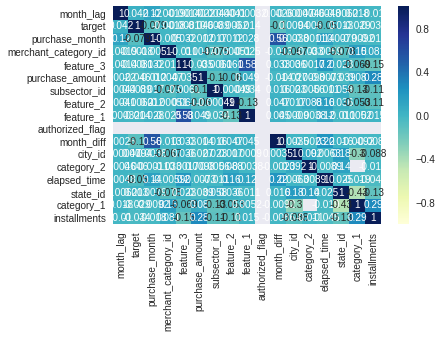

In [0]:
data_train_mod2_num_partcopy = data_train_mod2_num.iloc[:, :].copy()
sns.heatmap(data_train_mod2_num_partcopy.corr(), annot = True, cmap = "YlGnBu");

###### internal: distribution

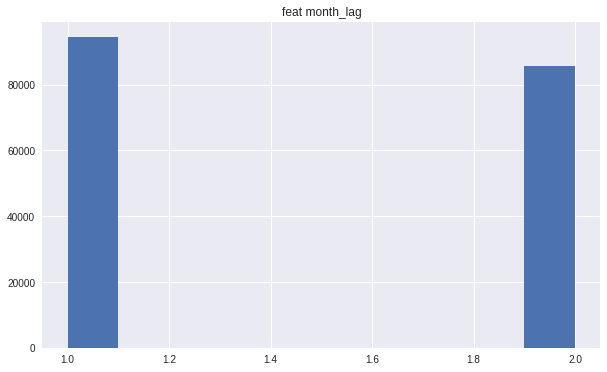

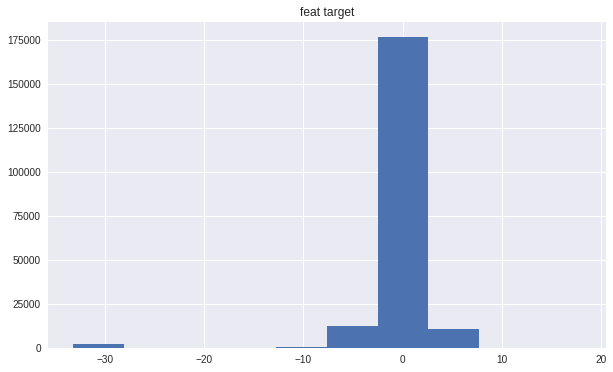

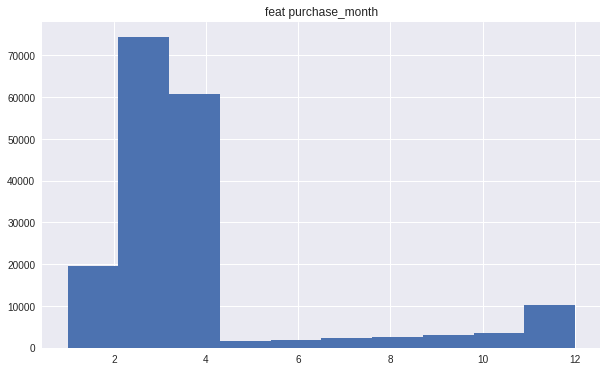

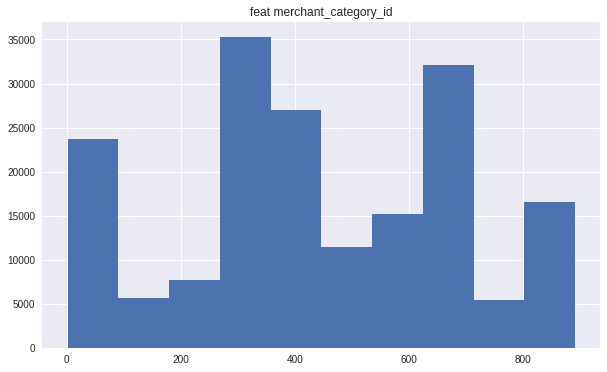

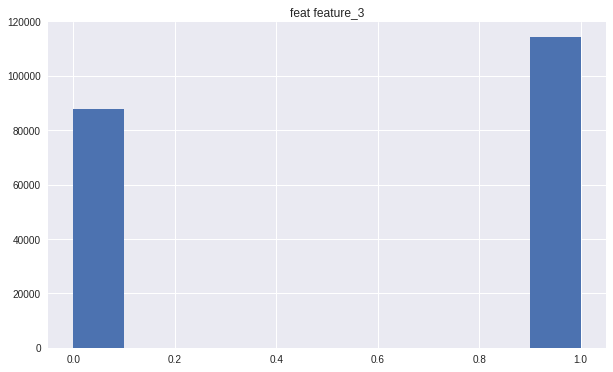

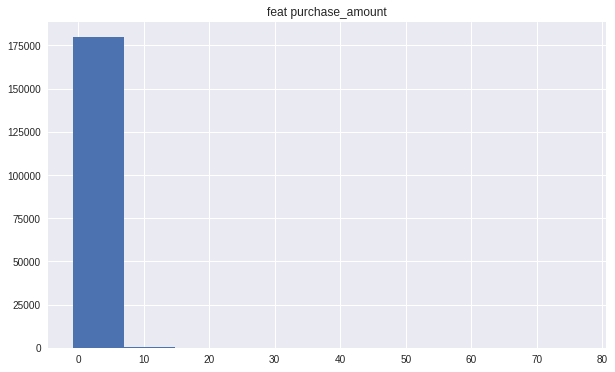

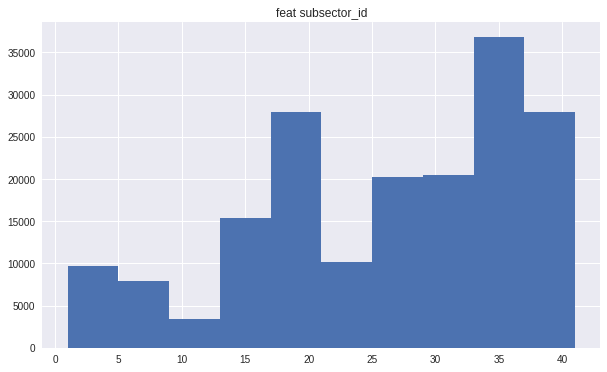

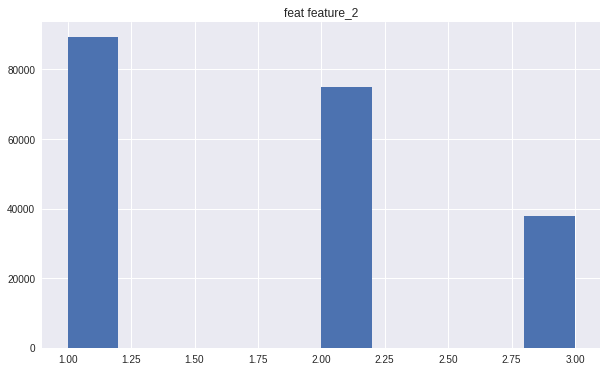

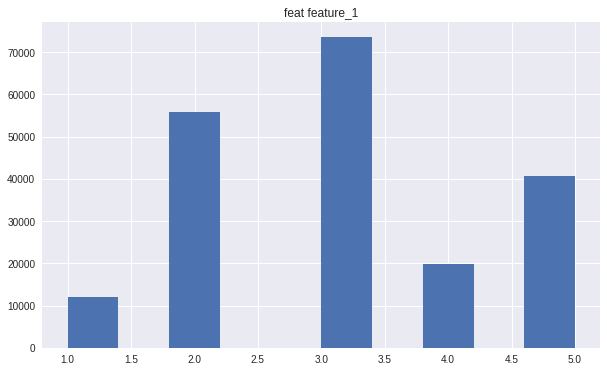

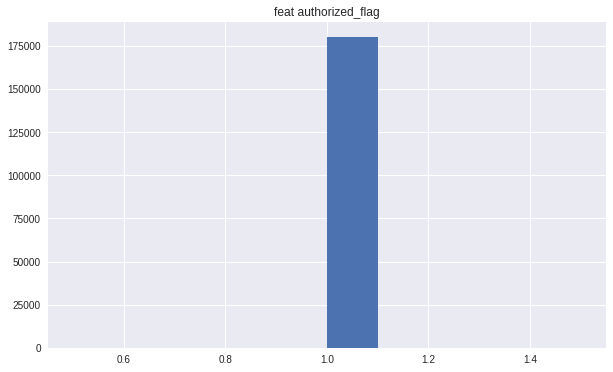

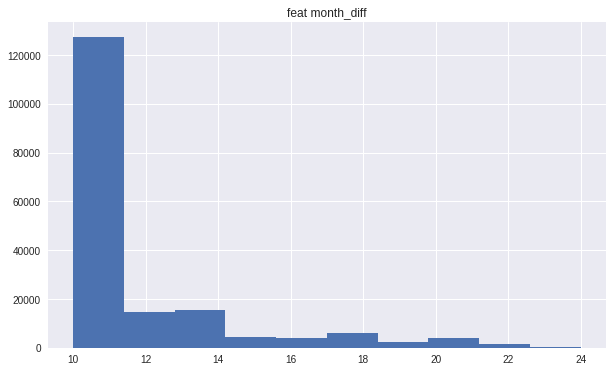

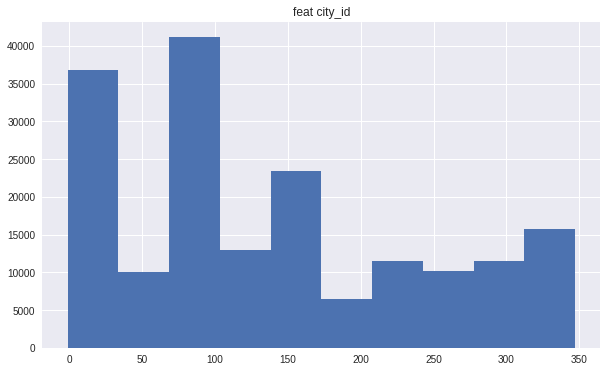

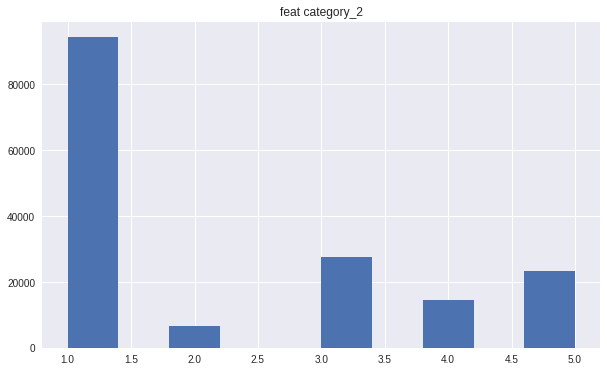

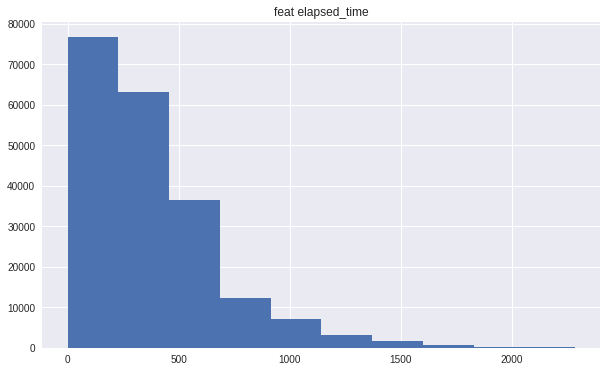

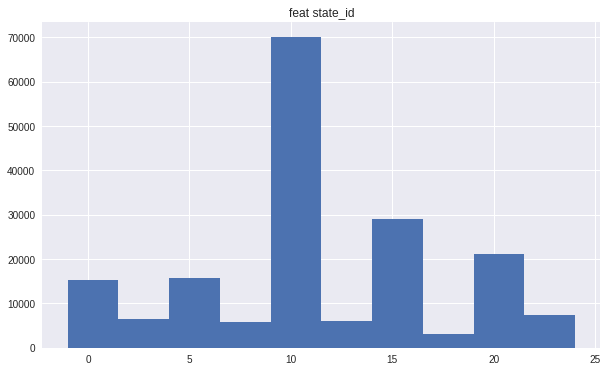

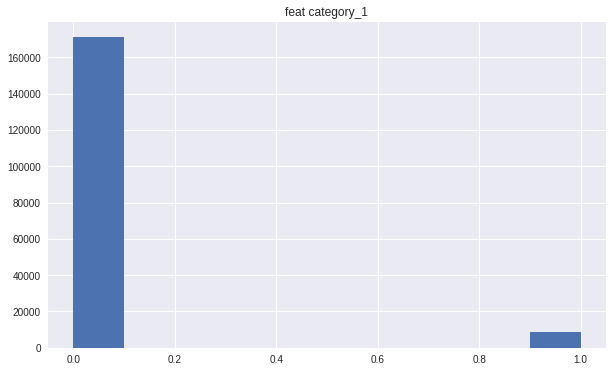

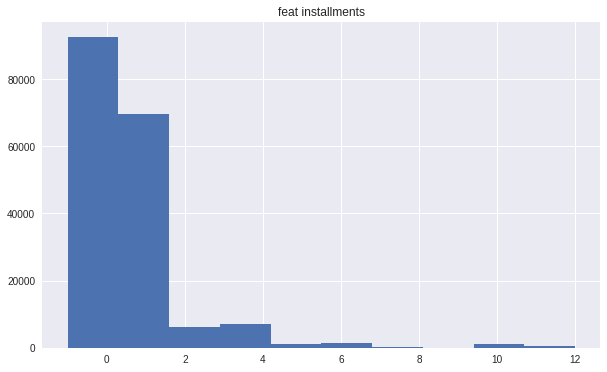

In [0]:
for indent, each_feat in enumerate(list(data_train_mod2_num.columns)):
    fig = plt.figure(num=indent, figsize=(10, 6))
    ax1 = fig.add_subplot(111)
    ax1.set_title("The distribution of feature %s" %each_feat)
    data_train_mod2_num.iloc[:, indent].hist(ax=ax1);

###### internal:  vacancy

In [0]:
data_train_mod2_vacancy_asses = data_train_mod2.isnull().sum()
data_train_mod2_vacancy_asses

[Output] Display column vacancy percentage distribution of training data: 


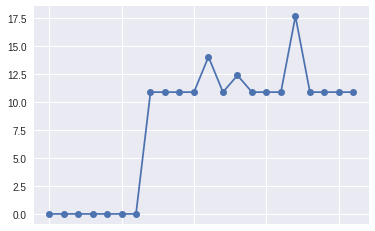

In [0]:
print("[Output] Display column vacancy percentage distribution of training data: ")
(100*data_train_mod2_vacancy_asses/len(data_train_mod2)).plot(marker="o");
# TODO 2019/1/24: add labels to every point

In [0]:
data_train_mod2_row_vacancy_asses = np.array([data_train_mod2.iloc[indent, :].isnull().sum() for indent in range(len(data_train_mod2))])
row_vacancy_ave = data_train_mod2_row_vacancy_asses.sum() / (len(data_train_mod2_row_vacancy_asses))
data_train_mod2_low = data_train_mod2[:][data_train_mod2_row_vacancy_asses <= row_vacancy_ave]  # lower than average number
data_train_mod2_high = data_train_mod2[:][data_train_mod2_row_vacancy_asses > row_vacancy_ave]  # higher than average number

[Output] Display row vacancy distribution of training data: 


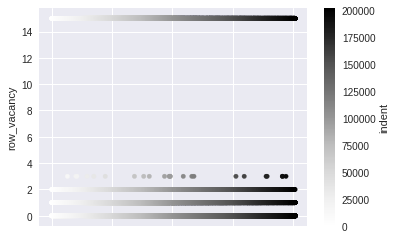

In [0]:
data_train_mod2_row_vacancy_asses_df = pd.DataFrame(data=data_train_mod2_row_vacancy_asses, columns=["row_vacancy"])
# print(data_train_mod2_row_vacancy_asses_df)
data_train_mod2_row_vacancy_asses_df["indent"] = list(data_train_mod2_row_vacancy_asses_df.index)
print("[Output] Display row vacancy distribution of training data: ")
data_train_mod2_row_vacancy_asses_df.plot.scatter(x="indent", y="row_vacancy", c="indent");

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


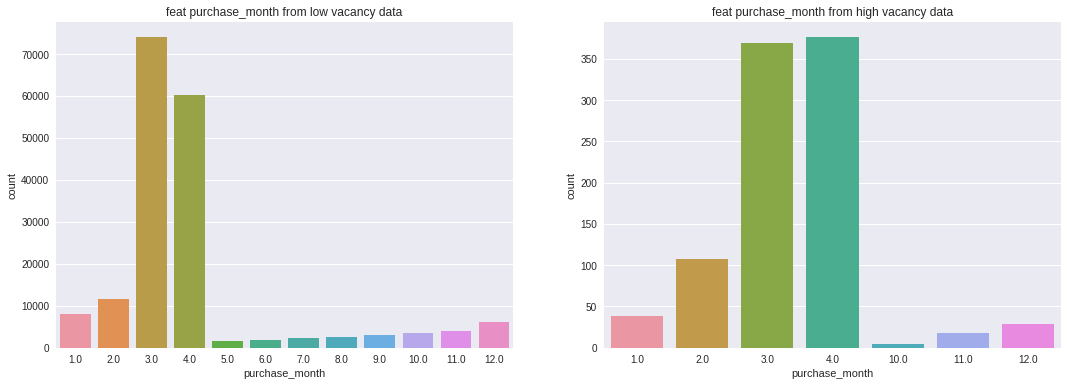

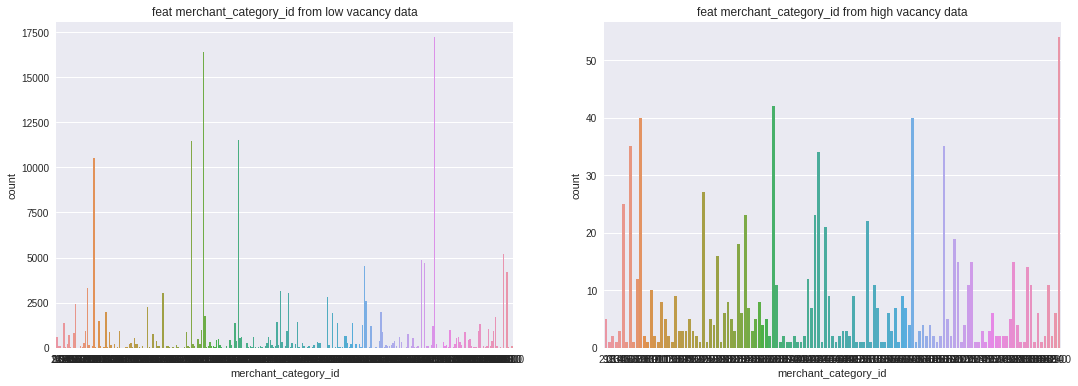

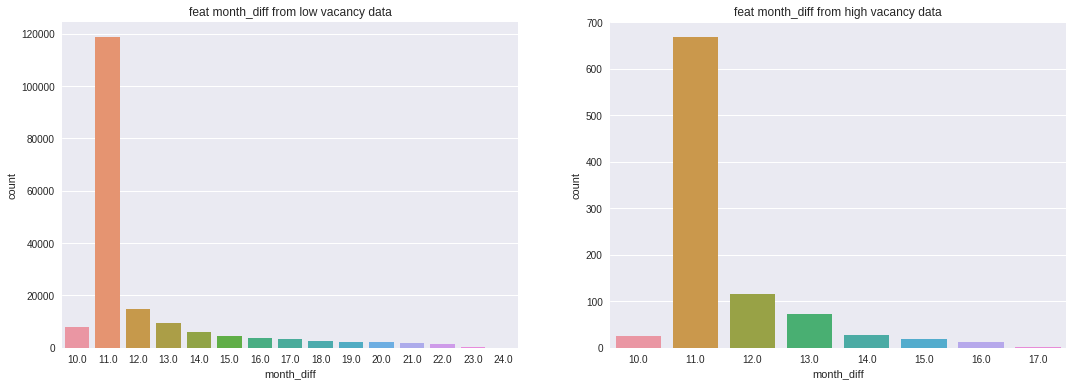

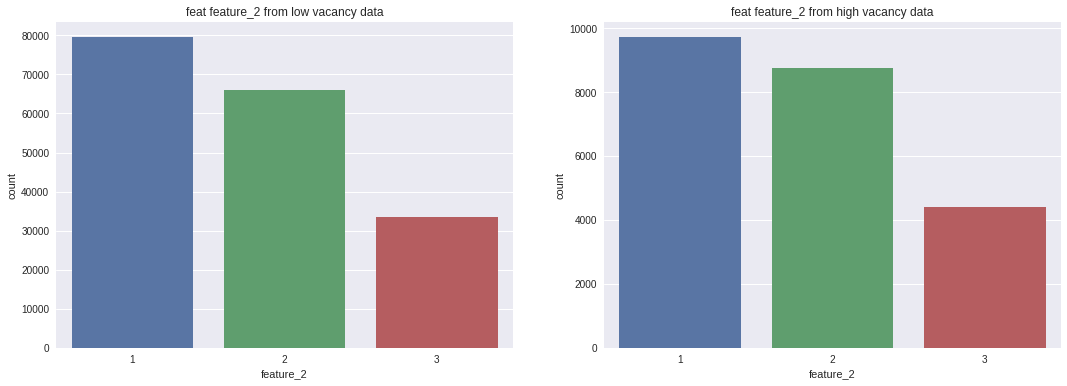

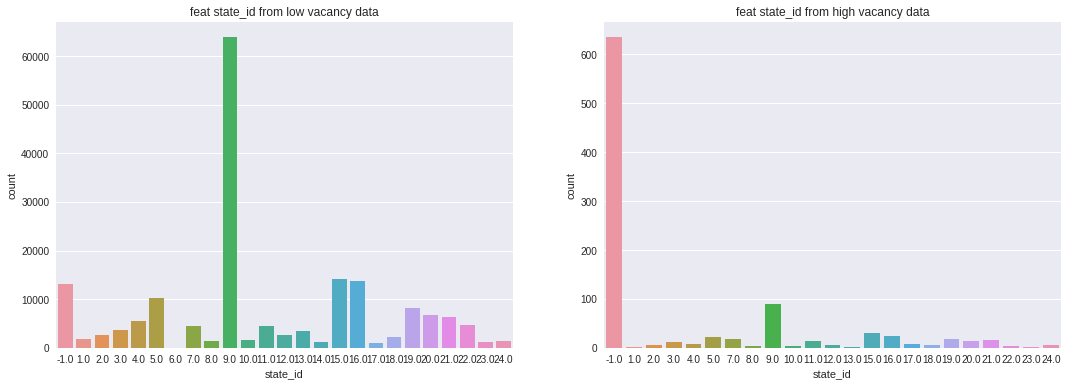

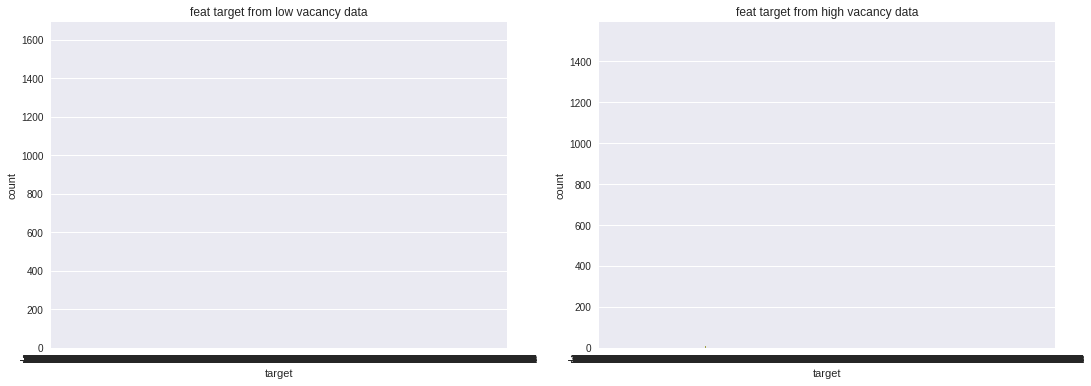

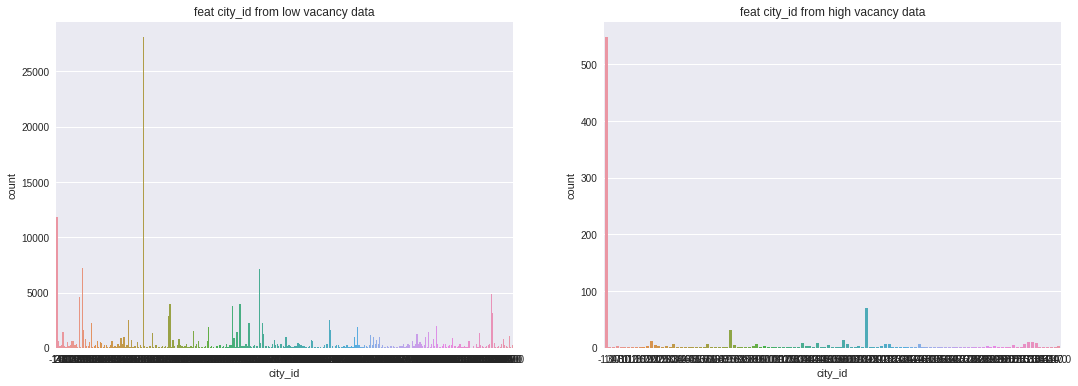

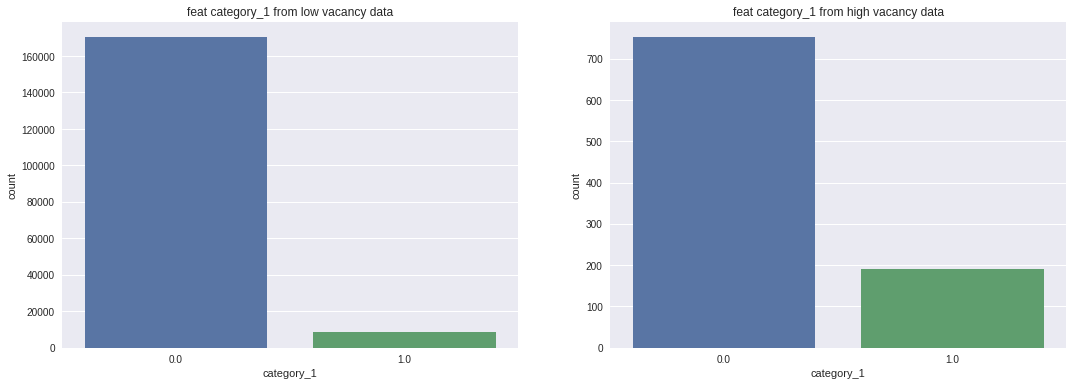

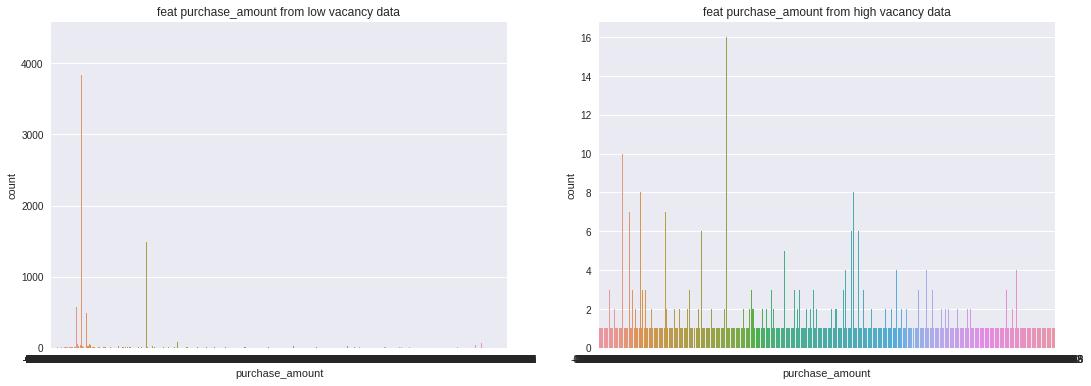

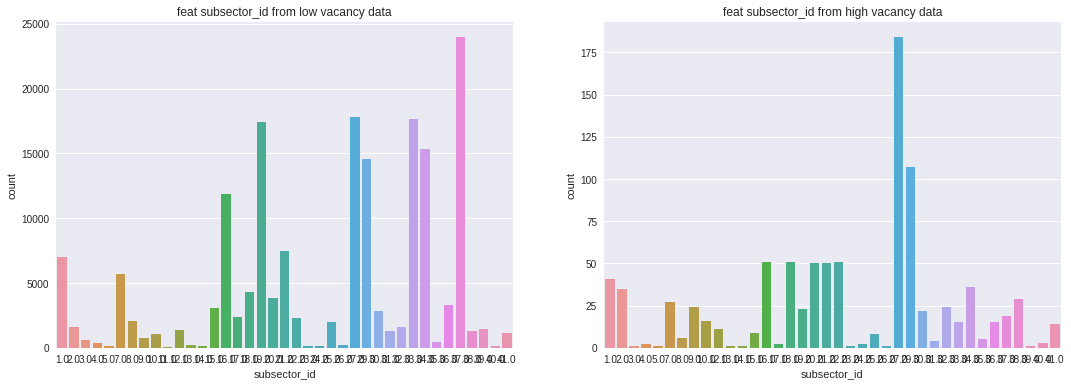

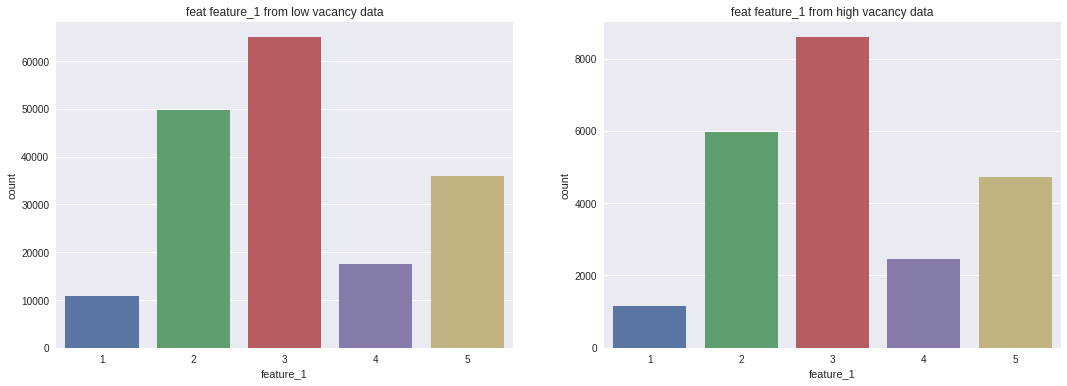

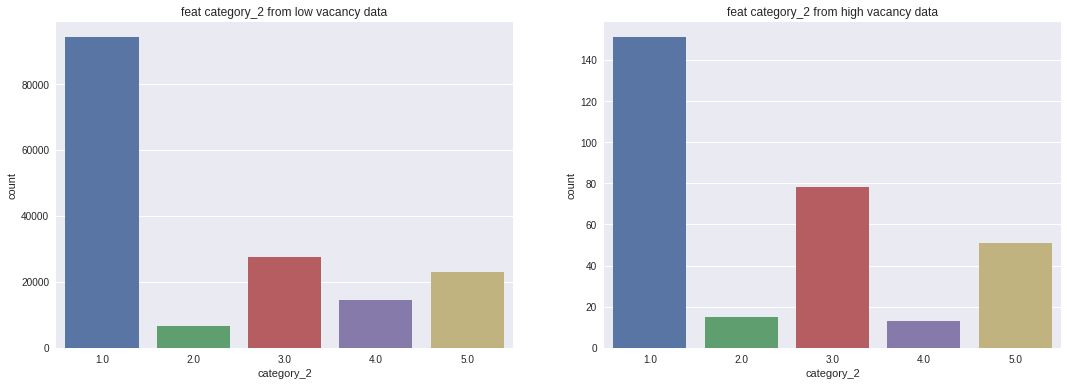

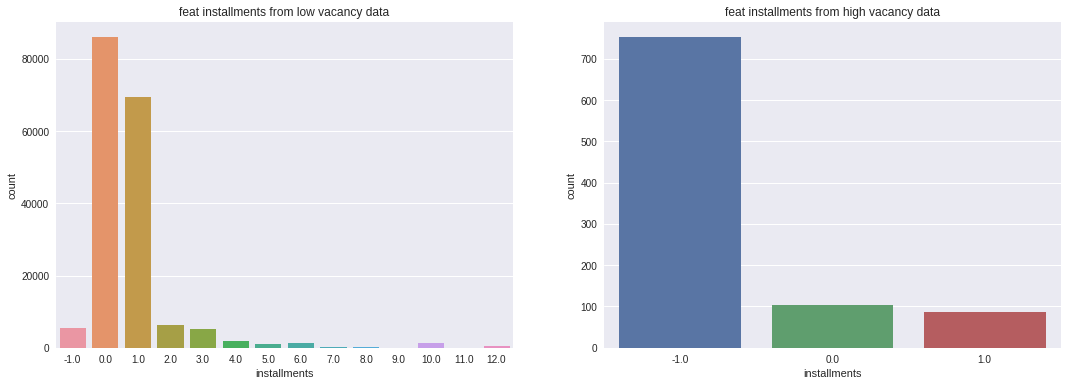

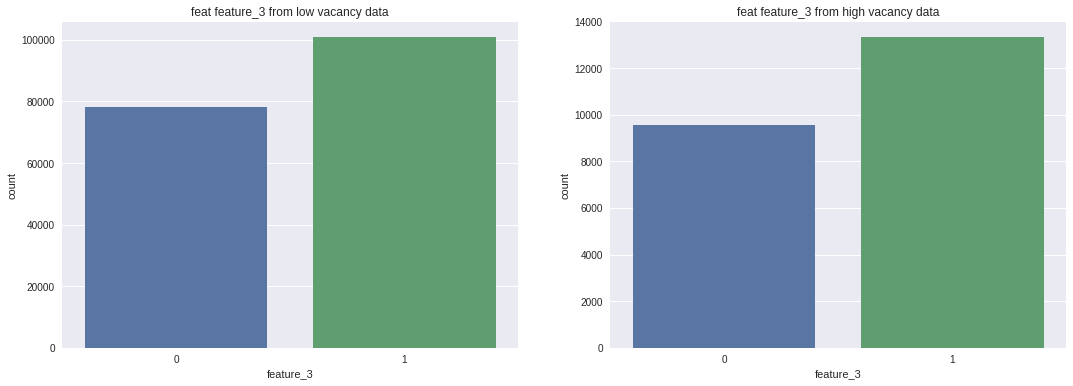

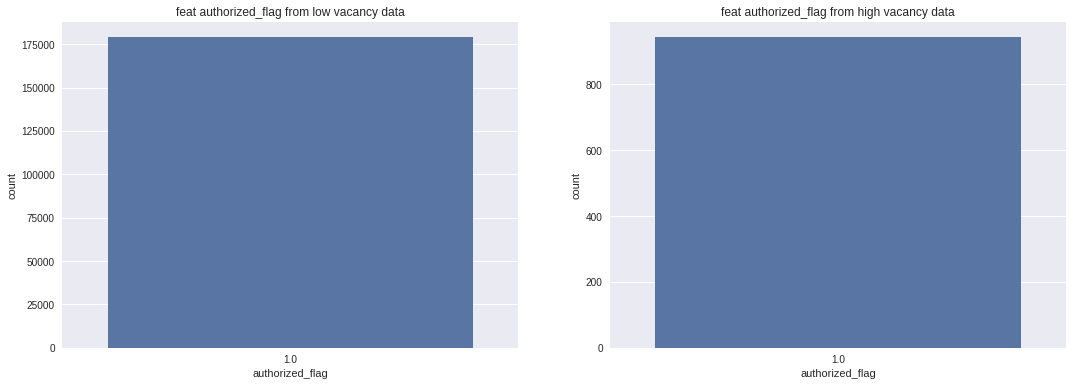

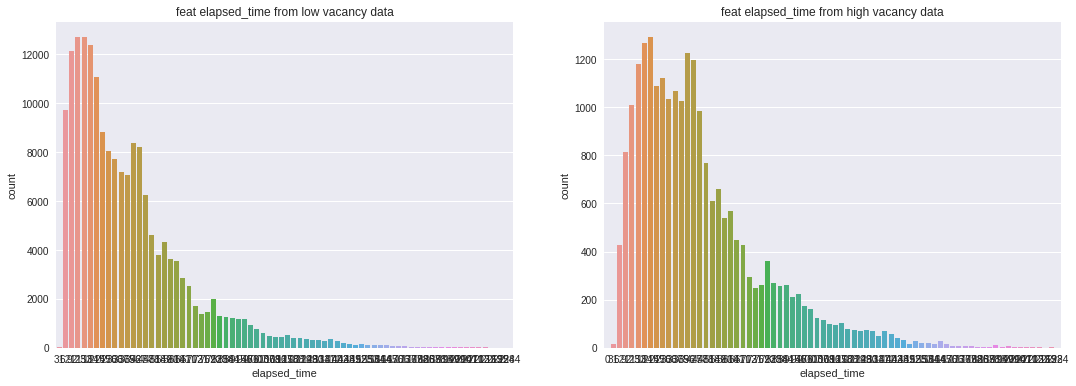

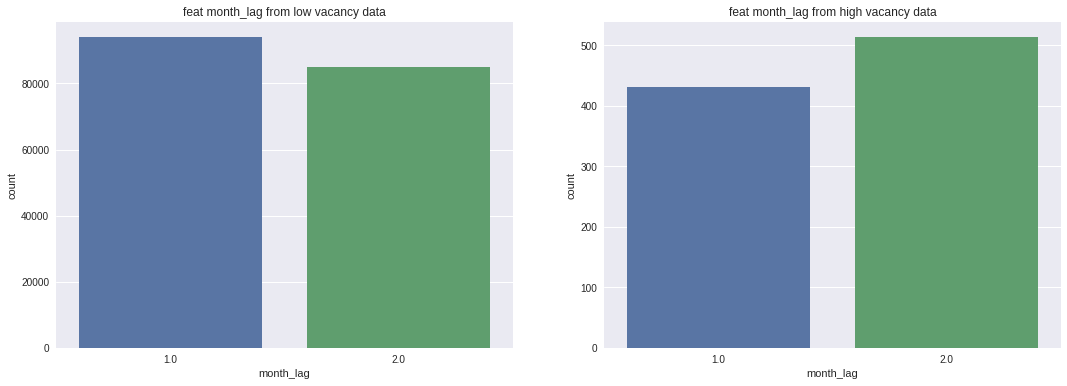

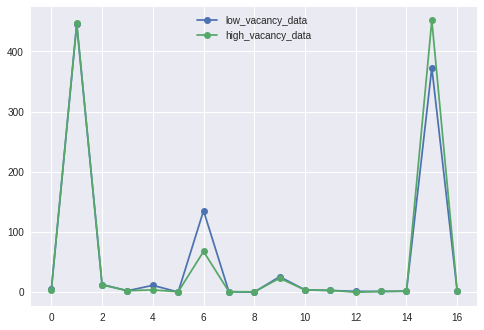

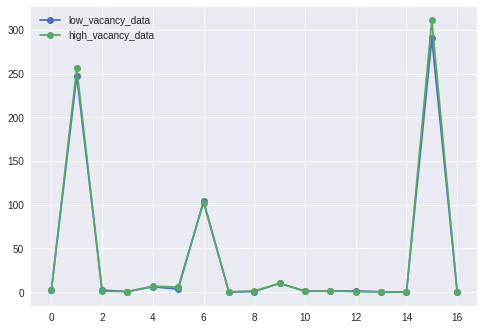

In [0]:
num = 16
mean_dict, std_dict = {"low_vacancy_data":[], "high_vacancy_data":[]}, {"low_vacancy_data":[], "high_vacancy_data":[]}
sns.set(style="darkgrid")
feat_selected = random.sample(list(data_train_mod2_columns_num), num)
for indent in range(num):
    compare_dis(data_train_mod2_low.loc[:, list(data_train_mod2_columns_num)], data_train_mod2_high.loc[:, list(data_train_mod2_columns_num)], feat_selected[indent], indent)
mean_df = pd.DataFrame(mean_dict)
std_df = pd.DataFrame(std_dict)
mean_df.plot(marker="o");
std_df.plot(marker="o");

###### conclusions

Conclusions at 2019/1/24:

- statistical analysis, distribution shows that "category_2" should be dropped: rejected(by the second analysis)
- vacancy relationships along row direction show that "city_id", "purchase_amount", "authorized_flag", "month_lag" should be dropped: accepted

In [0]:
choices = ["city_id", "purchase_amount", "authorized_flag", "month_lag"]
data_train_mod2 = data_train_mod2.drop(choices, axis=1)
[data_train_mod2_columns_num.remove(each_choice) for each_choice in choices];

##### numberical part of testing data

###### conclusions

Conclusions at 2019/1/24:

- considering assumption iid(independent and identically distributed), keep selections the same as what is applied to training data

In [0]:
choices = ["city_id", "purchase_amount", "authorized_flag", "month_lag"]
data_test_mod2 = data_test_mod2.drop(["city_id", "purchase_amount", "authorized_flag", "month_lag"], axis=1)
[data_test_mod2_columns_num.remove(each_choice) for each_choice in choices];

##### external: analysis between training data and testing data

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


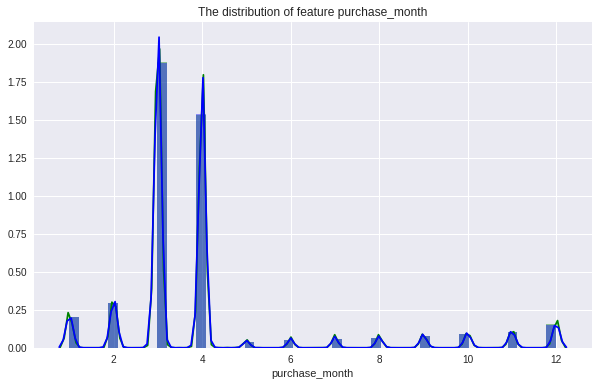

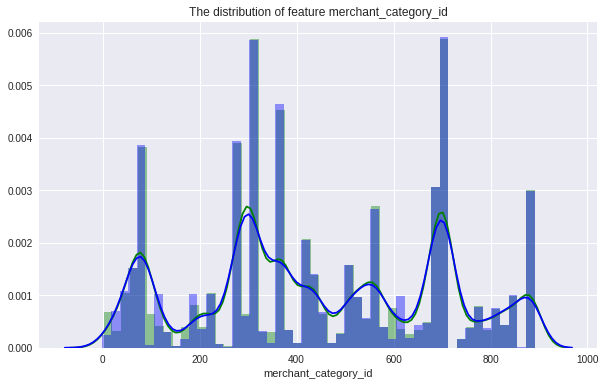

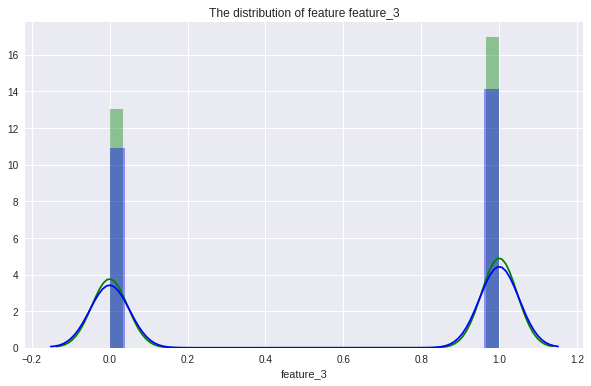

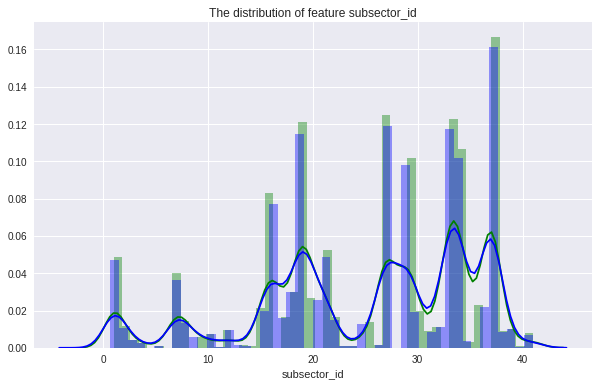

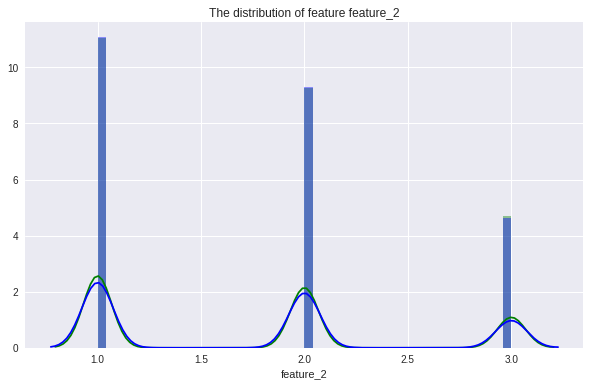

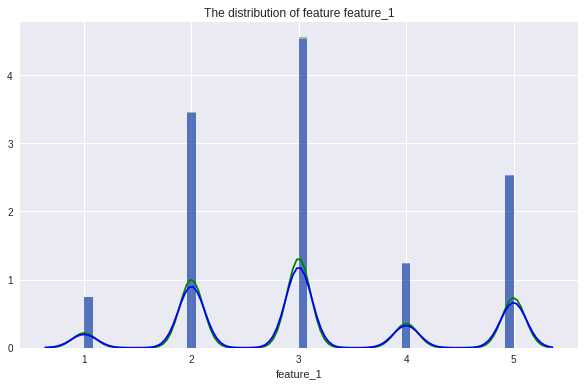

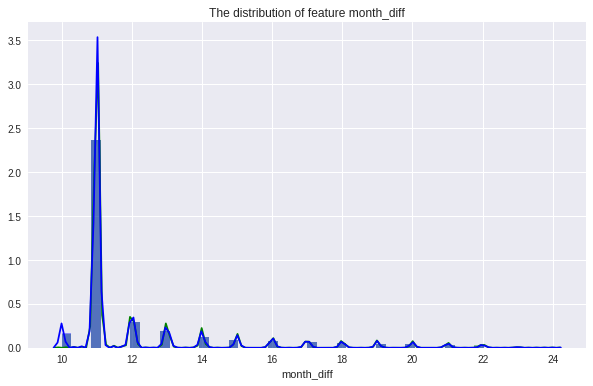

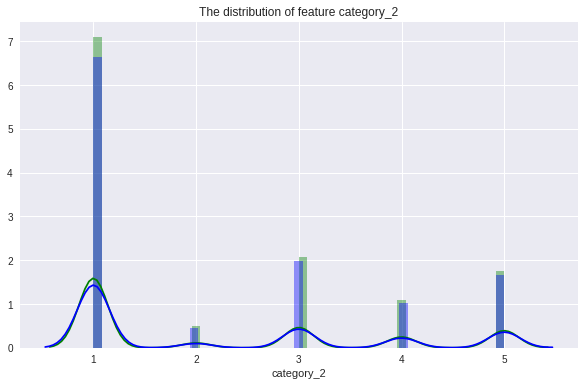

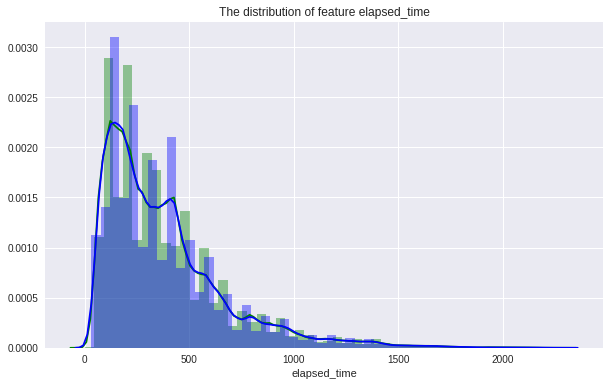

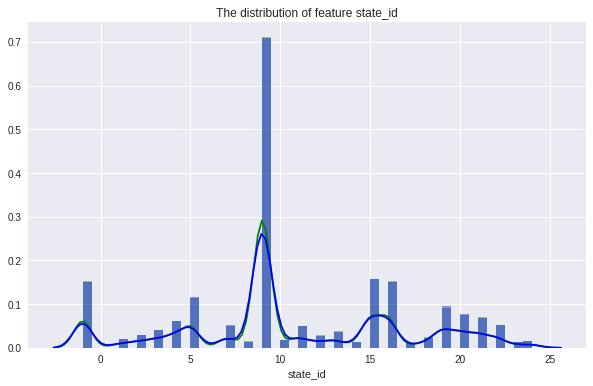

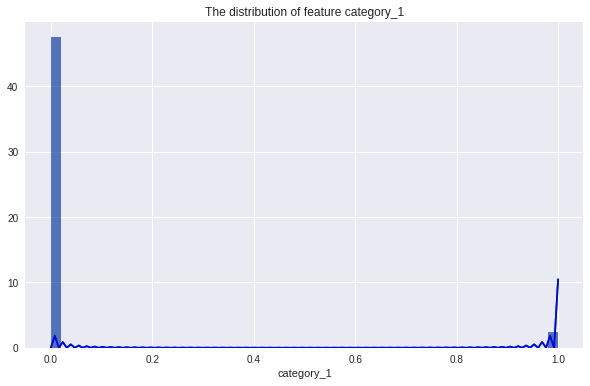

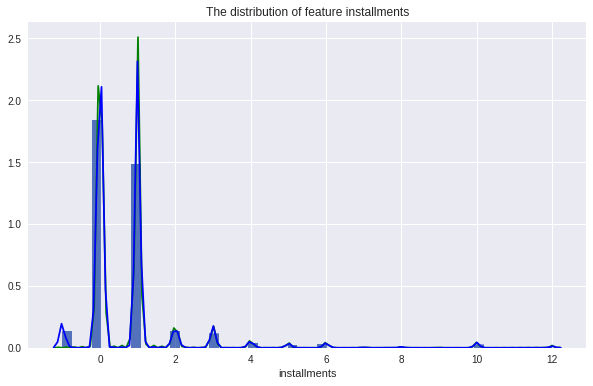

In [0]:
for indent, each_column in enumerate(data_test_mod2_columns_num):
    # feature = np.random.choice(list(data_test_mod2_columns_num_copy), select_num)
    # for indent in range(select_num):   
    fig = plt.figure(num=indent, figsize=(10, 6))
    ax1 = fig.add_subplot(111)
    ax1.set_title("The distribution of feature %s" %each_column)
    sns.distplot(data_train_mod2_num[each_column].dropna(), color="g", ax=ax1)
    sns.distplot(data_test_mod2_num[each_column].dropna(), color="b", ax=ax1)

###### conclusions

Conclusions at 2019/1/16:

- It seems like data needs expansion instead of squeezing because of the insufficient features and insufficient description of data
- Compare column vacancy, vacancy distributes nearly equally except for the original columns of training data(no vacancy)
- Compare row vacancy, different columns may not cause considerate distribution differences, which indicates no change will be applied

Conclusions at 2019/1/24:

- it seems difficult to distinguish training data and testing data from remaining numberical features

### fill NaNs

#### fill non-numberical data

In [0]:
data_train_mod2_nonnum.fillna(method="ffill", inplace=True)
data_test_mod2_nonnum.fillna(method="ffill", inplace=True)

In [0]:
data_train_mod2_nonnum.isnull().sum()

category_3            0
purchase_date         0
card_id.1             0
first_active_month    0
card_id               0
merchant_id           0
dtype: int64

In [0]:
# list(data_train_mod2_columns_nonnum) == list(data_train_mod2_columns_nonnum)
# list(data_test_mod2_columns_nonnum) == list(data_test_mod2_columns_nonnum)

In [0]:
data_train_mod2_columns_nonnum.remove("card_id")
data_train_mod2_columns_nonnum.remove("card_id.1")
data_train_mod2_columns_nonnum.remove("merchant_id")

data_test_mod2_columns_nonnum.remove("card_id")
data_test_mod2_columns_nonnum.remove("card_id.1")
data_test_mod2_columns_nonnum.remove("merchant_id")

##### deal mixed data

In [0]:
data_train_mod2_columns_nonnum

{'category_3', 'first_active_month', 'purchase_date'}

In [0]:
data_train_mod2_columns_nonnum.remove("purchase_date")
data_train_mod2_columns_nonnum.remove("first_active_month")

data_test_mod2_columns_nonnum.remove("purchase_date")
data_test_mod2_columns_nonnum.remove("first_active_month")

##### deal categorical data

In [0]:
data_train_mod2_nonnum_converted = pd.get_dummies(data_train_mod2_nonnum.loc[:, data_train_mod2_columns_nonnum])
data_test_mod2_nonnum_converted = pd.get_dummies(data_test_mod2_nonnum.loc[:, data_test_mod2_columns_nonnum])

#### fill numberical data

In [0]:
from sklearn.preprocessing import Imputer


filler_vacancy = Imputer()
data_train_mod2_num_nonull = pd.DataFrame(data=filler_vacancy.fit_transform(data_train_mod2_num), columns=data_train_mod2_num.columns)
data_test_mod2_num_nonull = pd.DataFrame(data=filler_vacancy.fit_transform(data_test_mod2_num), columns=data_test_mod2_num.columns)

data_train_mod2_num_nonull.set_index(data_train_mod2_nonnum_converted.index, inplace=True)
data_test_mod2_num_nonull.set_index(data_test_mod2_nonnum_converted.index, inplace=True)

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


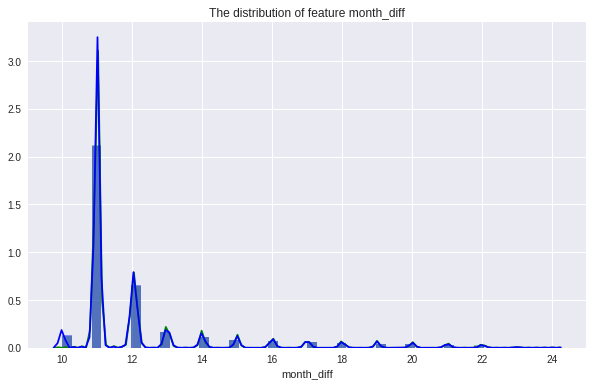

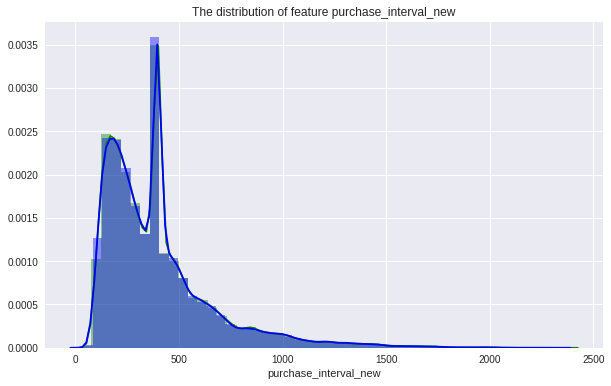

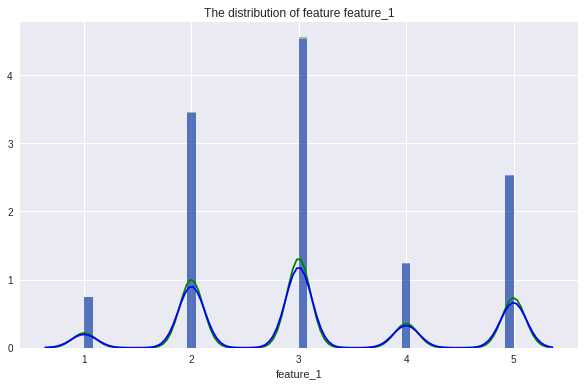

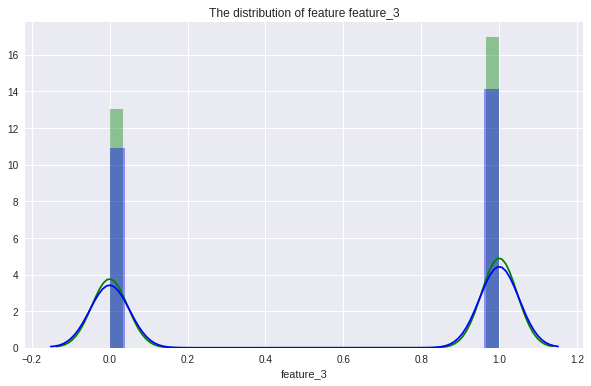

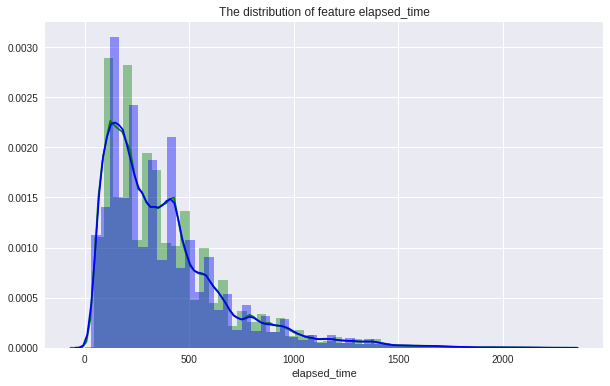

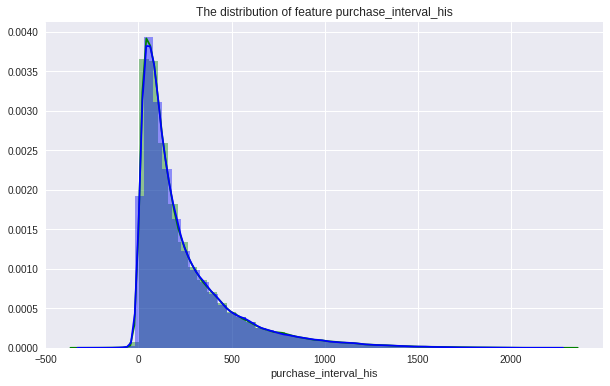

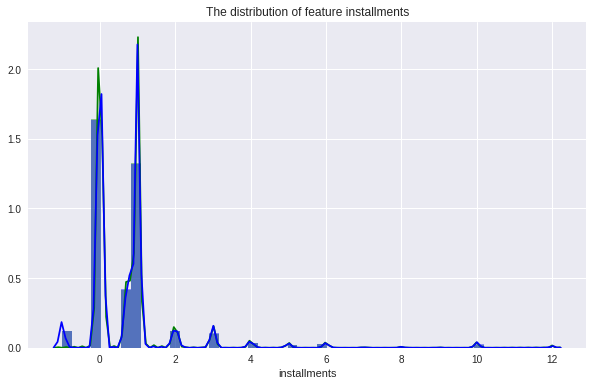

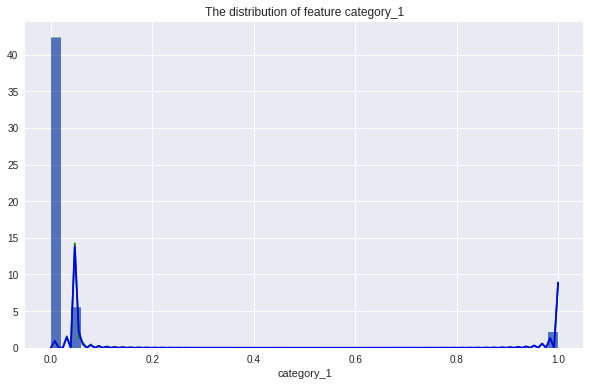

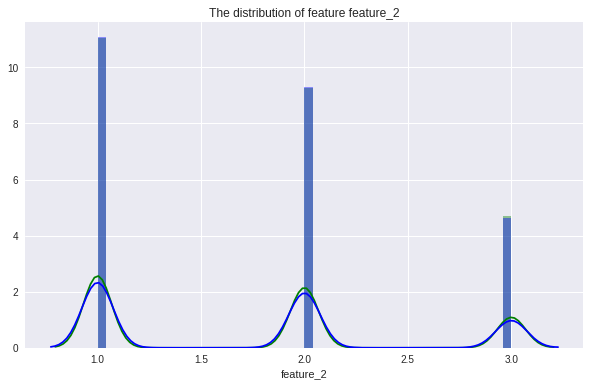

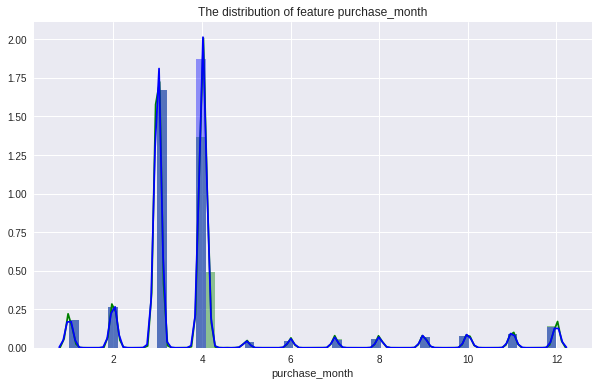

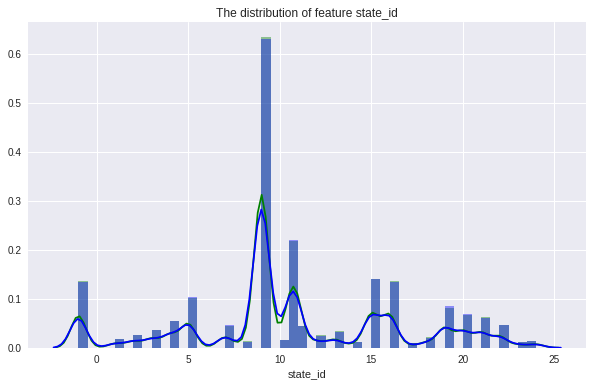

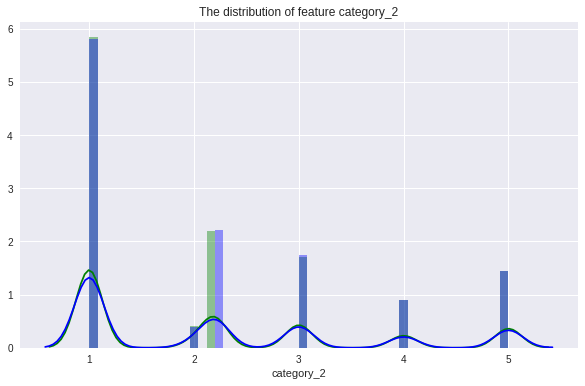

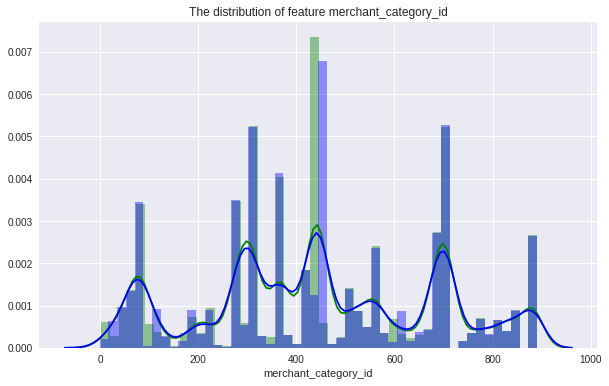

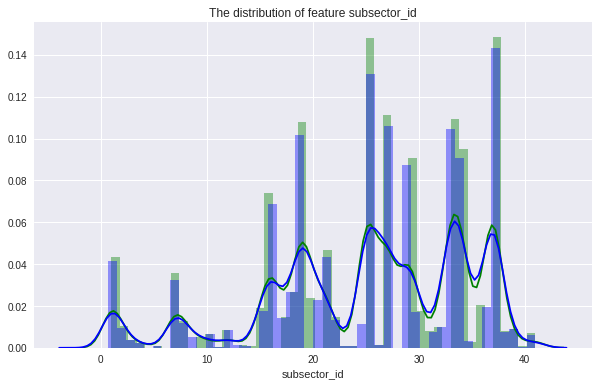

In [0]:
for indent, each_column in enumerate(data_test_mod2_columns_num):
    # feature = np.random.choice(list(data_test_mod2_columns_num_copy), select_num)
    # for indent in range(select_num):   
    fig = plt.figure(num=indent, figsize=(10, 6))
    ax1 = fig.add_subplot(111)
    ax1.set_title("The distribution of feature %s" %each_column)
    sns.distplot(data_train_mod2_num_nonull[each_column].dropna(), color="g", ax=ax1)
    sns.distplot(data_test_mod2_num_nonull[each_column].dropna(), color="b", ax=ax1)

### save data

In [0]:
data_train_full = pd.concat([data_train_mod2_nonnum_converted, data_train_mod2_num_nonull], axis=1)
data_test_full = pd.concat([data_test_mod2_nonnum_converted, data_test_mod2_num_nonull], axis=1)

# print("[Output] Save full training data after expansion, comparison and filling nan: ")
# data_train_full.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full.csv", index=None)
# data_train_full.to_csv("../data/data_processed/train/data_train_full.csv", index=None)
# print("[Output] Save full testing data  after expansion, comparison and filling nan: ")
# data_test_full.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full.csv", index=None)
# data_test_full.to_csv("../data/data_processed/test/data_test_full.csv", index=None)

[Output] Save full training data after expansion, comparison and filling nan: 
[Output] Save full testing data  after expansion, comparison and filling nan: 


In [0]:
def load_data2(flag):
    if flag == "fillingNaN":
        df_new1 = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full.csv")
        df_new2 = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full.csv")
    # elif flag == "dropNaN":
        # drop_list = ["card_id", "purchase_date", "first_active_month"]
        # df_new1 = data_train_mod2.dropna()
        # df_new2 = data_test_mod2.dropna()
        # df_new1.drop(drop_list, axis=1)
        # df_new2.drop(drop_list, axis=1)
    return df_new1, df_new2

In [0]:
data_train_full, data_test_full = load_data2("")

## last process

In [0]:
class process_last(self):
    def __init__(self):
        allocate room for the variable returned by class process_mid_c
        al
    def apply_scaler(self):
        use different scalers provided by sklearn with consideration of model feed
        return dataframe xxx_filled_scaled after scaling
    
    def select_feat(self):
        use algorithms like RF(SL), Kmeans(UL) or functions from sklearn
        return dataframe xxx_filled_scaled_selected after selection

### apply scaler

In [0]:
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import Normalizer


scaler_std = StandardScaler()
data_train_full_scaled = pd.DataFrame(data=scaler_std.fit_transform(data_train_full), columns=data_train_full.columns)
data_test_full_scaled = pd.DataFrame(data=scaler_std.fit_transform(data_test_full), columns=data_test_full.columns)

### select feat

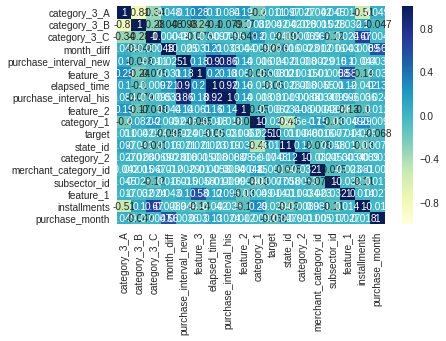

In [0]:
data_train_full_scaled_copy = copy.copy(data_train_full_scaled)
sns.heatmap(data_train_full_scaled_copy.corr(), annot = True, cmap = "YlGnBu");

In [0]:
from sklearn import feature_selection


# @functools.lru_cache(maxsize=128) 
def select_feature(features_num, data, labels):
    fselector = feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k=features_num)
    fselector.fit(data, labels)
    mask = fselector.get_support()
    indent = 0
    feature_names_selected = []
    for indent in range(len(mask)):
        if mask[indent]:
            feature_names_selected.append(list(data.columns)[indent])
        gc.collect()
        sys._clear_type_cache()
    return  feature_names_selected

In [0]:
labels_train = data_train["target"].astype("float")

In [0]:
labels_train = [math.floor(item) for item in data_train_full["target"].astype("float")]
data_train_part_scaled = data_train_full_scaled.drop(["target"], axis=1)
feature_train_selected = select_feature(12, data_train_part_scaled, labels_train)
data_train_full_scaled_selected = data_train_full_scaled.loc[:, feature_train_selected]
data_test_full_scaled_selected = data_test_full_scaled.loc[:, feature_train_selected]

### save data

In [0]:
print("[Output] Save sacled training data after expansion, comparison and filling nan: ")
data_train_full_scaled.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full_scaled.csv", index=None)
# data_train_full.to_csv("../data/data_processed/train/data_train_full_scaled.csv", index=None)
print("[Output] Save scaled testing data after expansion, comparison and filling nan: ")
data_test_full_scaled.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full_scaled.csv", index=None)
# data_test_full.to_csv("../data/data_processed/test/data_test_full_scaled.csv", index=None)

print("[Output] Save selected training data after expansion, comparison, filling nan and scaling: ")
data_train_full_scaled_selected.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full_scaled_selected.csv", index=None)
print("[Output] Save selected testing data after expansion, comparison, filling nan and scaling: ")
data_test_full_scaled_selected.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full_scaled_selected.csv", index=None)

[Output] Save sacled training data after expansion, comparison and filling nan: 
[Output] Save scaled testing data  after expansion, comparison and filling nan: 


In [0]:
data_train_full_scaled2 = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full_scaled.csv")
data_test_full_scaled2 = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full_scaled.csv")
data_train_full_scaled_selected = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_full_scaled_selected.csv")
data_test_full_scaled_selected = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_full_scaled_selected.csv")

# Test Parts

In [0]:
import gc, sys
gc.collect()
sys._clear_type_cache()

#####  simple data transportation from new transaction and historical transaction data

In [0]:
# @functools.lru_cache(maxsize=128)  # TypeError: "DataFrame" objects are mutable, thus they cannot be hashed
def expand_data(data_ori, data_external, column_ref, expand_flag):
    
    # columns_added = [each_column if each_column not in data_ori.columns else "Exisisted" for each_column in data_external.columns]
    
    if len(data_ori) == len(set(data_ori.loc[:, column_ref])):
        pass
    else:
        pass # TODO 2019/1/9: how to deal this situation? 
    data_new = copy.copy(data_ori)
    data_external_mod1 = copy.copy(data_external) 
    data_external_mod1.drop_duplicates(subset="card_id", inplace=True)  # TODO 2019/1/14: how to deal with the duplicate transaction record? 
    columns_added = []
    for each_column in data_external.columns:
        if each_column not in data_ori.columns:
            columns_added.append(each_column)
            data_new[each_column] = np.array([np.nan] * len(data_ori))
    
    # content = [data_external[columns_added][data_external[column_ref]==index] for index in data_ori[column_ref]]  # TODO 2019/1/9: a more efficient way to expand whole data?
    
    id_inter = list(set(data_new[column_ref]).intersection(set(data_external_mod1[column_ref])))
    # return(id_inter)
    data_new.set_index(data_new[column_ref], inplace=True)
    data_external_mod1.set_index(data_external_mod1[column_ref], inplace=True)   
    data_new.loc[id_inter, columns_added] = data_external_mod1.loc[id_inter, columns_added]  # TODO 2019/1/11: ValueError: cannot reindex from a duplicate axis
    data_new_copy = copy.copy(data_new)
    if expand_flag == "new":
        data_new.loc[id_inter, "purchase_interval_new"] = (data_external_mod1.loc[id_inter, "purchase_date"].dt.date - data_new_copy.loc[id_inter,"first_active_month"].dt.date).dt.days
    elif expand_flag == "his":
        data_new.loc[id_inter, "purchase_interval_his"] = (data_external_mod1.loc[id_inter, "purchase_date"].dt.date - data_new_copy.loc[id_inter,"first_active_month"].dt.date).dt.days        
    gc.collect()
    sys._clear_type_cache()
    return data_new

In [0]:
data_train_mod1 = expand_data(data_train, data_new_merchant_transactions, "card_id", "new")
data_train_mod2 = expand_data(data_train_mod1, data_historical_transactions, "card_id", "his")
print("[Output] Save expanded training data by raw data file {}: ".format("data_new_merchant_transactions"))
data_train_mod1.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_expanded.csv")
print("[Output] Save expanded training data by raw data file {} and {}: ".format("data_new_merchant_transactions", "data_historical_transactions"))
data_train_mod2.to_csv(DATA_ROOT_PATH+"data_processed/train/data_train_expanded2.csv")

[Output] Save expanded training data by raw data file data_new_merchant_transactions: 
[Output] Save expanded training data by raw data file data_new_merchant_transactions and data_historical_transactions: 


In [0]:
data_test_mod1 = expand_data(data_test, data_new_merchant_transactions, "card_id", "new")
data_test_mod2 = expand_data(data_test_mod1, data_historical_transactions, "card_id", "his")
print("[Output] Save expanded testing data by raw data file {}: ".format("data_new_merchant_transactions"))
data_test_mod1.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_expanded.csv")
print("[Output] Save expanded testing data by raw data file {} and {}: ".format("data_new_merchant_transactions", "data_historical_transactions"))
data_test_mod2.to_csv(DATA_ROOT_PATH+"data_processed/test/data_test_expanded2.csv")

[Output] Save expanded testing data by raw data file data_new_merchant_transactions: 
[Output] Save expanded testing data by raw data file data_new_merchant_transactions and data_historical_transactions: 


In [0]:
data_train_mod1 = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_expanded.csv")
data_train_mod2 = pd.read_csv(DATA_ROOT_PATH+"data_processed/train/data_train_expanded2.csv")
data_test_mod1 = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_expanded.csv")
data_test_mod2 = pd.read_csv(DATA_ROOT_PATH+"data_processed/test/data_test_expanded2.csv")

## for data

### by pandas

In [0]:
df..plot.scatter/bar/...

In [0]:
df.isnull.sum().mean()  # provide a pandas series of the percentage of each row vacancy

In [0]:
df.columnA.value_counts()  # provide a pandas series of the counts for a specified column

In [0]:
df["Sample_mod"] = df["Sample"].apply(func_sample)

In [0]:
df.style.bar(subset=["Sample"], align="mid", color=["#d65f5f", "#5fba7d"])

In [0]:
month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August',
                'September', 'October', 'November', 'December']
temp['purchase_month'] = pd.Categorical(temp['purchase_month'], categories = month_labels, 
                                          ordered = True)

### by ?

## for algorithm or package

In [0]:
import tushare as ts


data_stock = ts.get_hist_data("600519")
data_stock.isna().sum()
# data_stock.index
print(data_stock.columns, type(data_stock))

## Table Forms

Forms provide an easy way to parameterize code. From a code cell, select **Insert → Add form field**.  When you change the value in a form, the corresponding value in the code will change. 

In [0]:
#@title String fields

text = 'value' #@param {type:"string"}
dropdown = '1st option' #@param ["1st option", "2nd option", "3rd option"]
text_and_dropdown = 'value' #@param ["1st option", "2nd option", "3rd option"] {allow-input: true}

print(text)
print(dropdown)
print(text_and_dropdown)

In [0]:
#@title Raw fields

raw_input = None #@param {type:"raw"}
raw_dropdown = raw_input #@param [1, "raw_input", "False", "'string'"] {type:"raw"}

print(raw_input)
print(raw_dropdown)

In [0]:
#@title Date fields
date_input = '2018-03-22' #@param {type:"date"}

print(date_input)

In [0]:
#@title Number fields
number_input = 10.0 #@param {type:"number"}
number_slider = 0 #@param {type:"slider", min:-1, max:1, step:0.1}

integer_input = 10 #@param {type:"integer"}
integer_slider = 1 #@param {type:"slider", min:0, max:100, step:1}

print(number_input)
print(number_slider)

print(integer_input)
print(integer_slider)

In [0]:
#@title Boolean fields
boolean_checkbox = True #@param {type:"boolean"}
boolean_dropdown = True #@param ["False", "True"] {type:"raw"}

print(boolean_checkbox)
print(boolean_dropdown)

### Hiding code

You can change the view of the form by selecting **Edit → Show/hide code** or using the toolbar above the selected code cell. You can see both code and the form, just the form, or just the code.

In [0]:
#@title ## Markdown
#@markdown You can also include Markdown in forms.

#@markdown ---
#@markdown ### Enter a file path:
file_path = "" #@param {type:"string"}
#@markdown ---

